# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
import glidertools as gt

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [2]:
FOLDER_OUTPUT = '/home/dIOGOLOC/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

# Extraindo informações dos arquivos ".mseed"

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [4]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime]], index=['filename', 'mergulho', 'stream_number','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [5]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|█████████████████████████████████| 109315/109315 [01:02<00:00, 1760.64it/s]


In [6]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)


In [7]:
dataframe_mseed_final

filename mergulho stream_number           starttime  \
0       pa0002au_003_151112_144018     0002           003 2015-11-12 14:40:18   
1       pa0001au_004_151112_135441     0001           004 2015-11-12 13:54:41   
2       pa0001au_001_151112_134841     0001           001 2015-11-12 13:48:41   
3       pa0002au_004_151112_144218     0002           004 2015-11-12 14:42:18   
4       pa0002au_005_151112_144418     0002           005 2015-11-12 14:44:18   
...                            ...      ...           ...                 ...   
109310  pa0238au_012_191010_210037     0238           012 2019-10-10 21:00:37   
109311  pa0238au_007_191010_201036     0238           007 2019-10-10 20:10:36   
109312  pa0238au_015_191010_213037     0238           015 2019-10-10 21:30:37   
109313  pa0238au_017_191010_215037     0238           017 2019-10-10 21:50:37   
109314  pa0238au_016_191010_214037     0238           016 2019-10-10 21:40:37   

                       endtime  
0      2015-11-12 14:42:17.930  
1      2015-11-12 13:56:40.930  
2      2015-11-12 13:50:40.930  
3      2015-11-12 14:44:17.930  
4      2015-11-12 14:46:17.930  
...                        ...  
109310 2019-10-10 21:10:36.990  
109311 2019-10-10 20:20:35.990  
109312 2019-10-10 21:40:36.990  
109313 2019-10-10 21:59:05.130  
109314 2019-10-10 21:50:36.990  

[109315 rows x 5 columns]

# Extraindo informações dos arquivos ".csv"

In [8]:
filename_csv = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

In [9]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

time                                 filename  \
0      2015-11-12 13:48:40.999995  pa0001au_001_151112_134841_rms_spl3.mat   
1      2015-11-12 13:49:41.000001  pa0001au_001_151112_134841_rms_spl3.mat   
2      2015-11-12 13:50:40.999998  pa0001au_002_151112_135041_rms_spl3.mat   
3      2015-11-12 13:51:41.000004  pa0001au_002_151112_135041_rms_spl3.mat   
4      2015-11-12 13:52:41.000001  pa0001au_003_151112_135241_rms_spl3.mat   
...                           ...                                      ...   
547748 2021-11-04 06:52:38.000000  pa0296au_011_211104_064338_rms_spl3.mat   
547749 2021-11-04 06:53:37.999997  pa0296au_012_211104_065338_rms_spl3.mat   
547750 2021-11-04 06:54:38.000003  pa0296au_012_211104_065338_rms_spl3.mat   
547751 2021-11-04 06:55:38.000000  pa0296au_012_211104_065338_rms_spl3.mat   
547752 2021-11-04 06:56:37.999996  pa0296au_012_211104_065338_rms_spl3.mat   

         latitude  longitude       depth  
0      -23.825157 -42.495483    1.314286  
1      -23.824950 -42.495487    7.415555  
2      -23.824745 -42.495490   15.776000  
3      -23.824540 -42.495495   24.372000  
4      -23.824331 -42.495500   32.912000  
...           ...        ...         ...  
547748 -24.461742 -42.471264  866.012900  
547749 -24.461819 -42.471302  873.586100  
547750 -24.461980 -42.471510  879.579600  
547751 -24.462152 -42.471740  884.380700  
547752 -24.462324 -42.471966  888.467200  

[547753 rows x 5 columns]

In [10]:
dataframe_csv['year'] = dataframe_csv['time'].dt.strftime("%Y")
dataframe_csv['month'] = dataframe_csv['time'].dt.strftime("%m")
dataframe_csv['n_month'] = dataframe_csv['time'].dt.strftime("%b")
dataframe_csv['depth'] = dataframe_csv['depth'] * -1

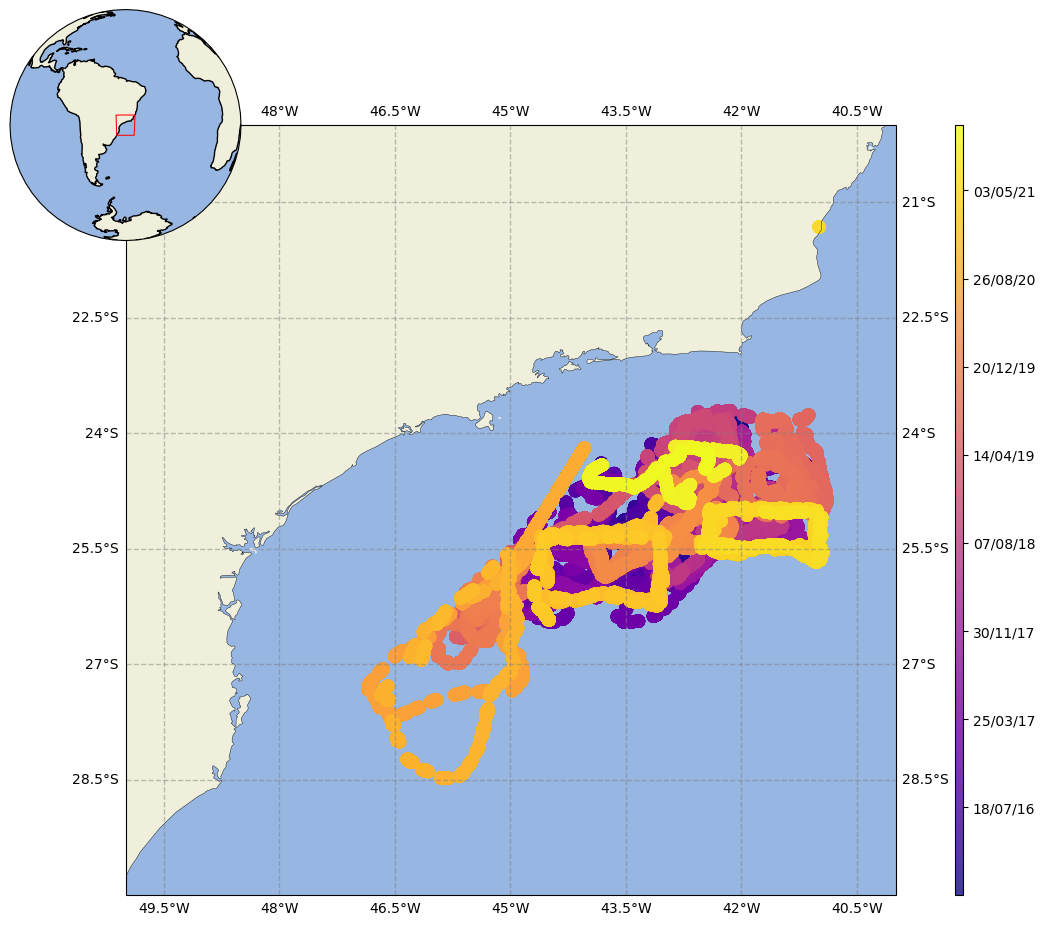

In [11]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Selecionando um evento: 

In [12]:
START_DATE_EV = "2019-01-01"

FINAL_DATE_EV = "2019-12-31"

MIN_MAG_EV = 5.5

In [13]:
client = Client("IRIS")

events = client.get_events(starttime=UTCDateTime(START_DATE_EV).date,endtime=UTCDateTime(FINAL_DATE_EV).date,minmagnitude=MIN_MAG_EV)

print("Found %s event(s)" % len(events))

Found 434 event(s)


In [14]:
events

434 Event(s) in Catalog:
2019-12-30T17:18:57.673000Z | +35.590,  +74.628 | 5.5 Mww
2019-12-28T15:36:35.773000Z | -44.608,  +37.094 | 5.7 Mww
...
2019-01-05T18:47:11.740000Z | +51.335, -178.118 | 5.9 Mww
2019-01-04T06:22:45.630000Z |  -6.518, +130.407 | 5.6 Mww
To see all events call 'print(CatalogObject.__str__(print_all=True))'

 24%|█████████▋                               | 103/434 [02:45<09:06,  1.65s/it]/tmp/ipykernel_211848/1921197058.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)
 26%|██████████▍                              | 111/434 [05:48<31:00,  5.76s/it]/tmp/ipykernel_211848/1921197058.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)
 29%|████████████                             | 128/434 [09:00<08:28,  1.66s/it]/tmp/ipykernel_211848/1921197058.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projec

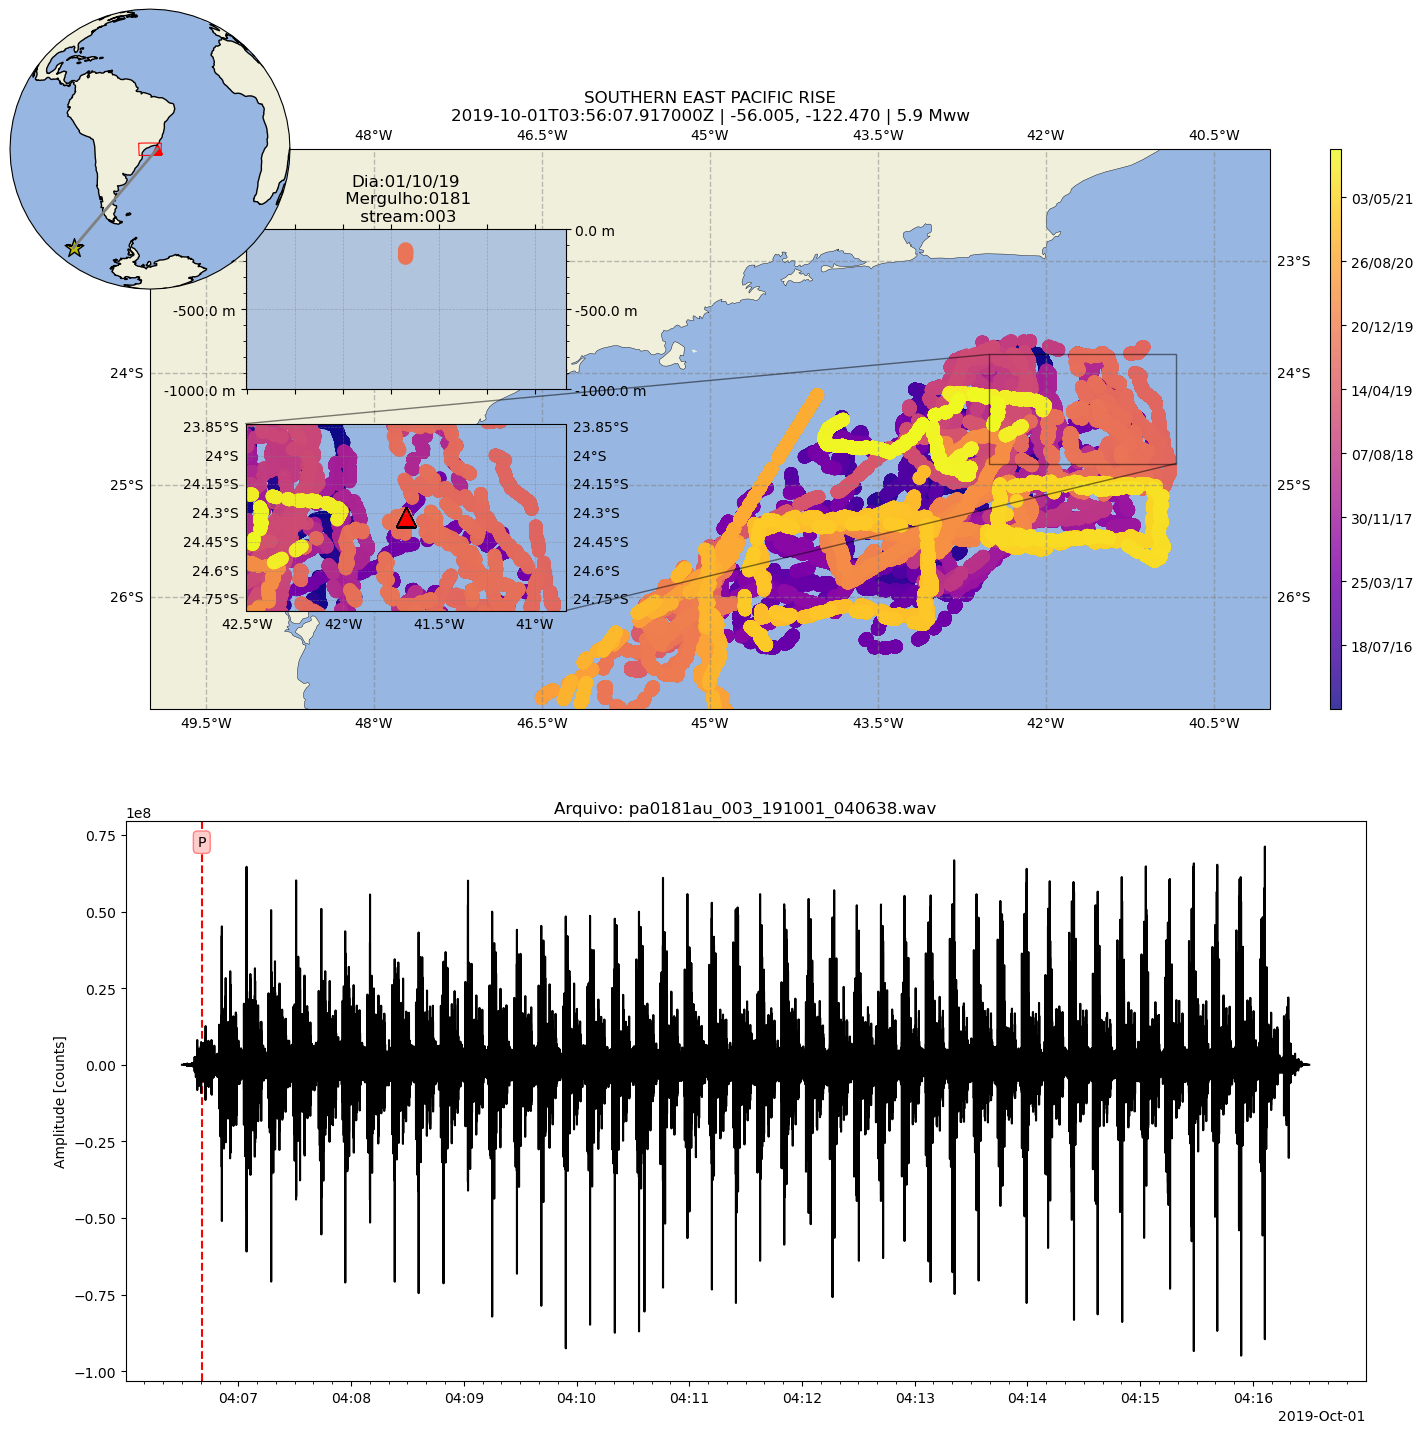

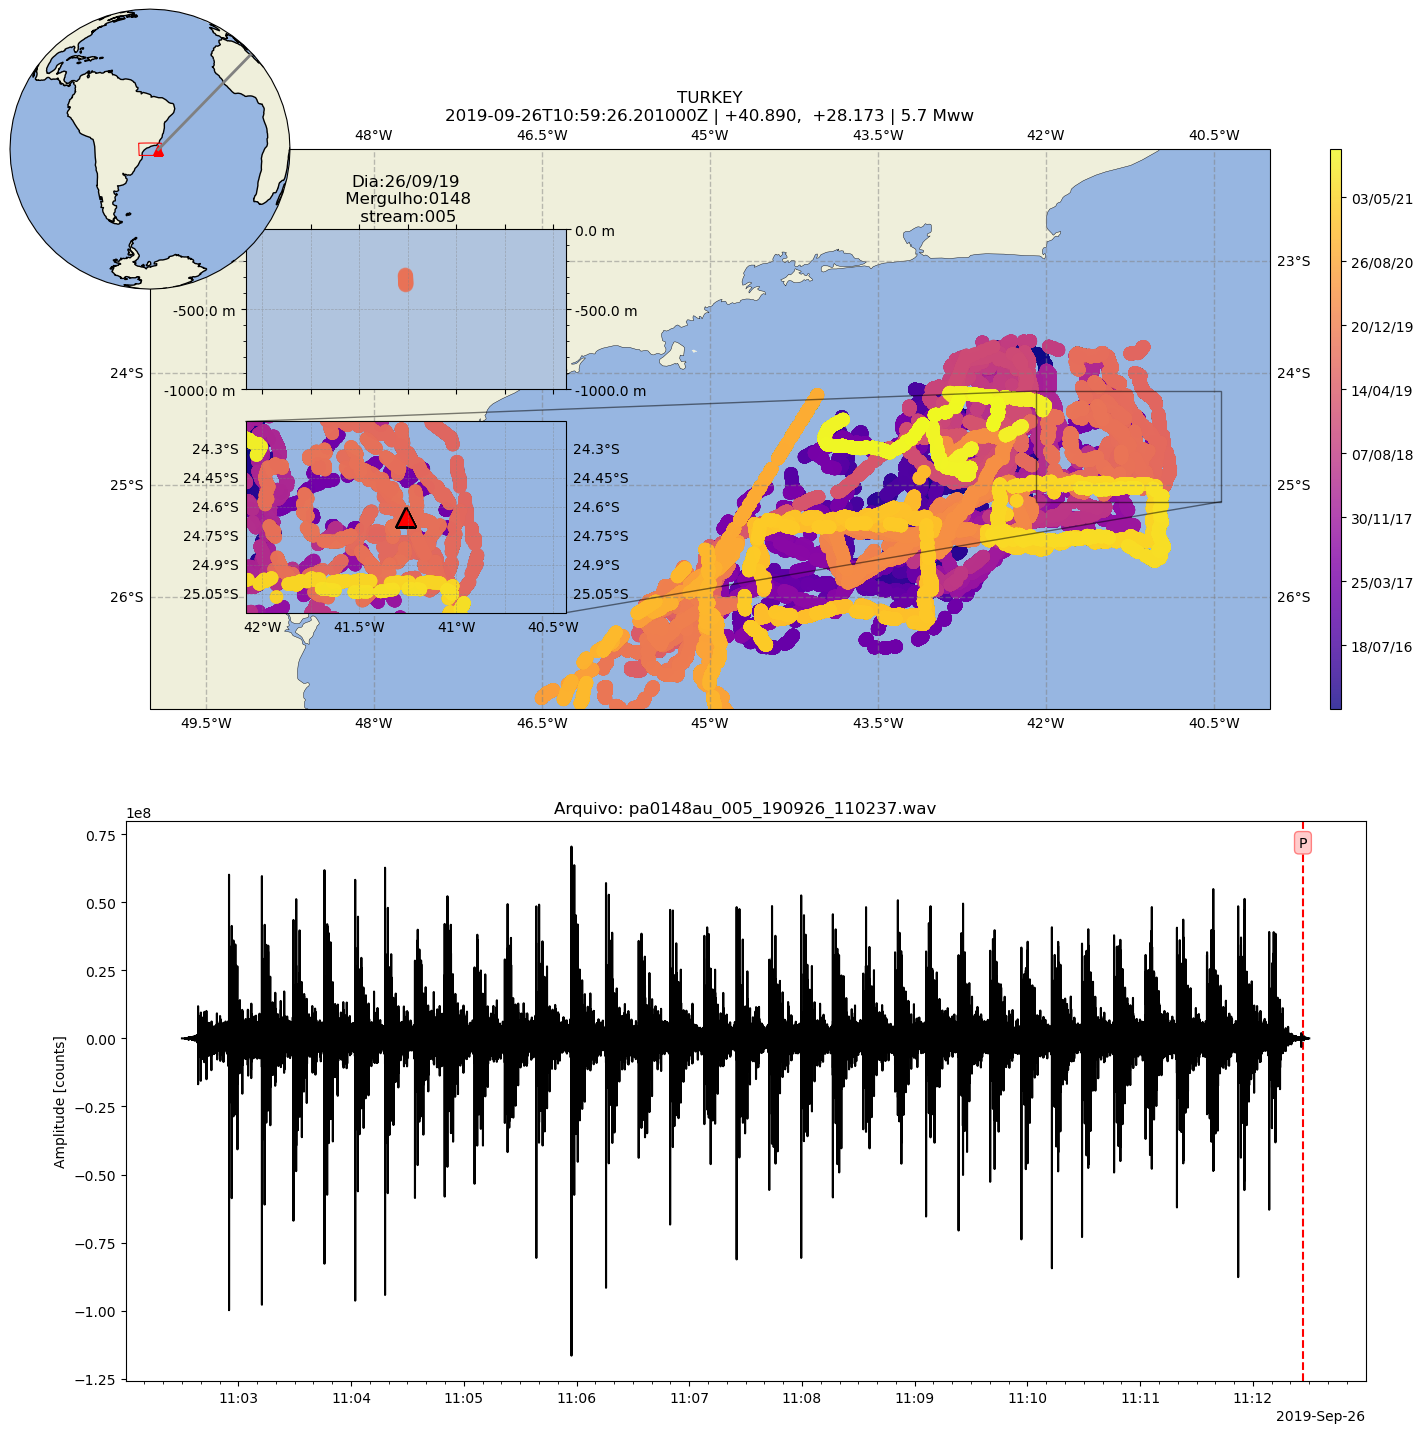

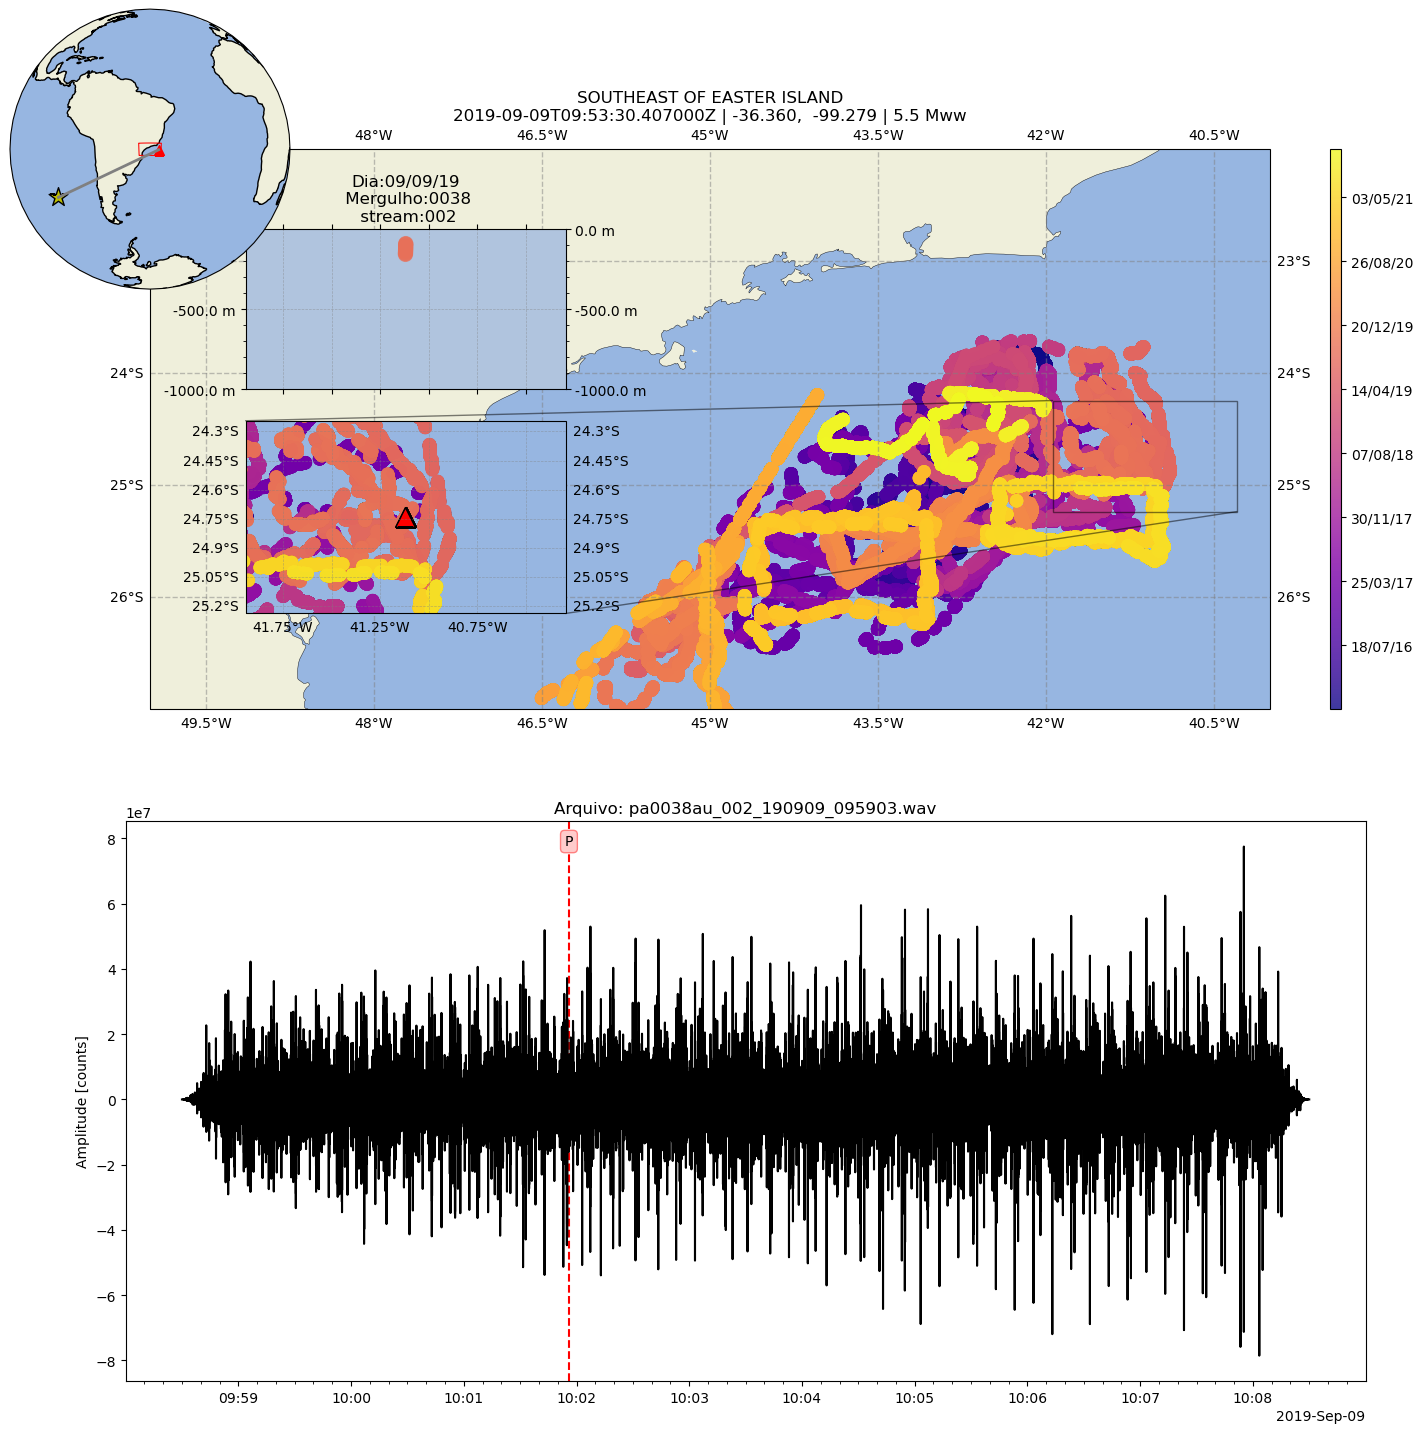

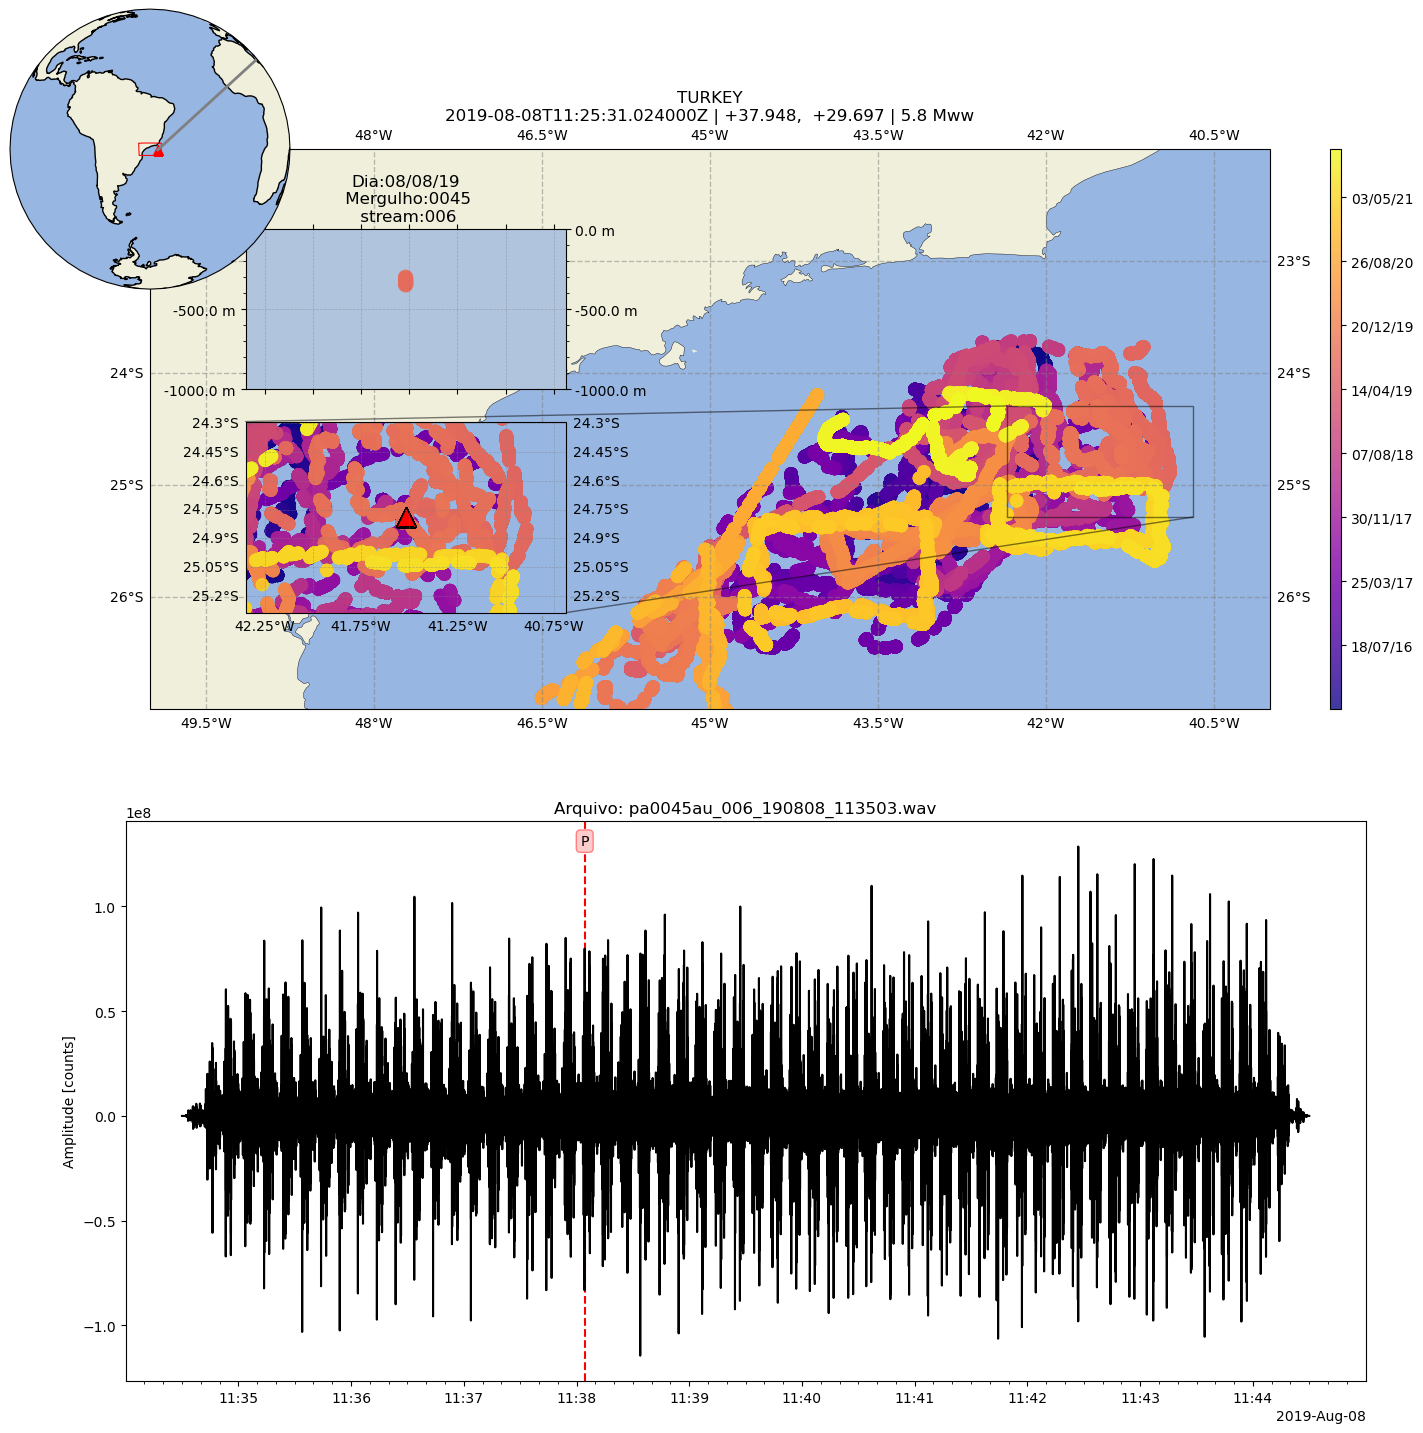

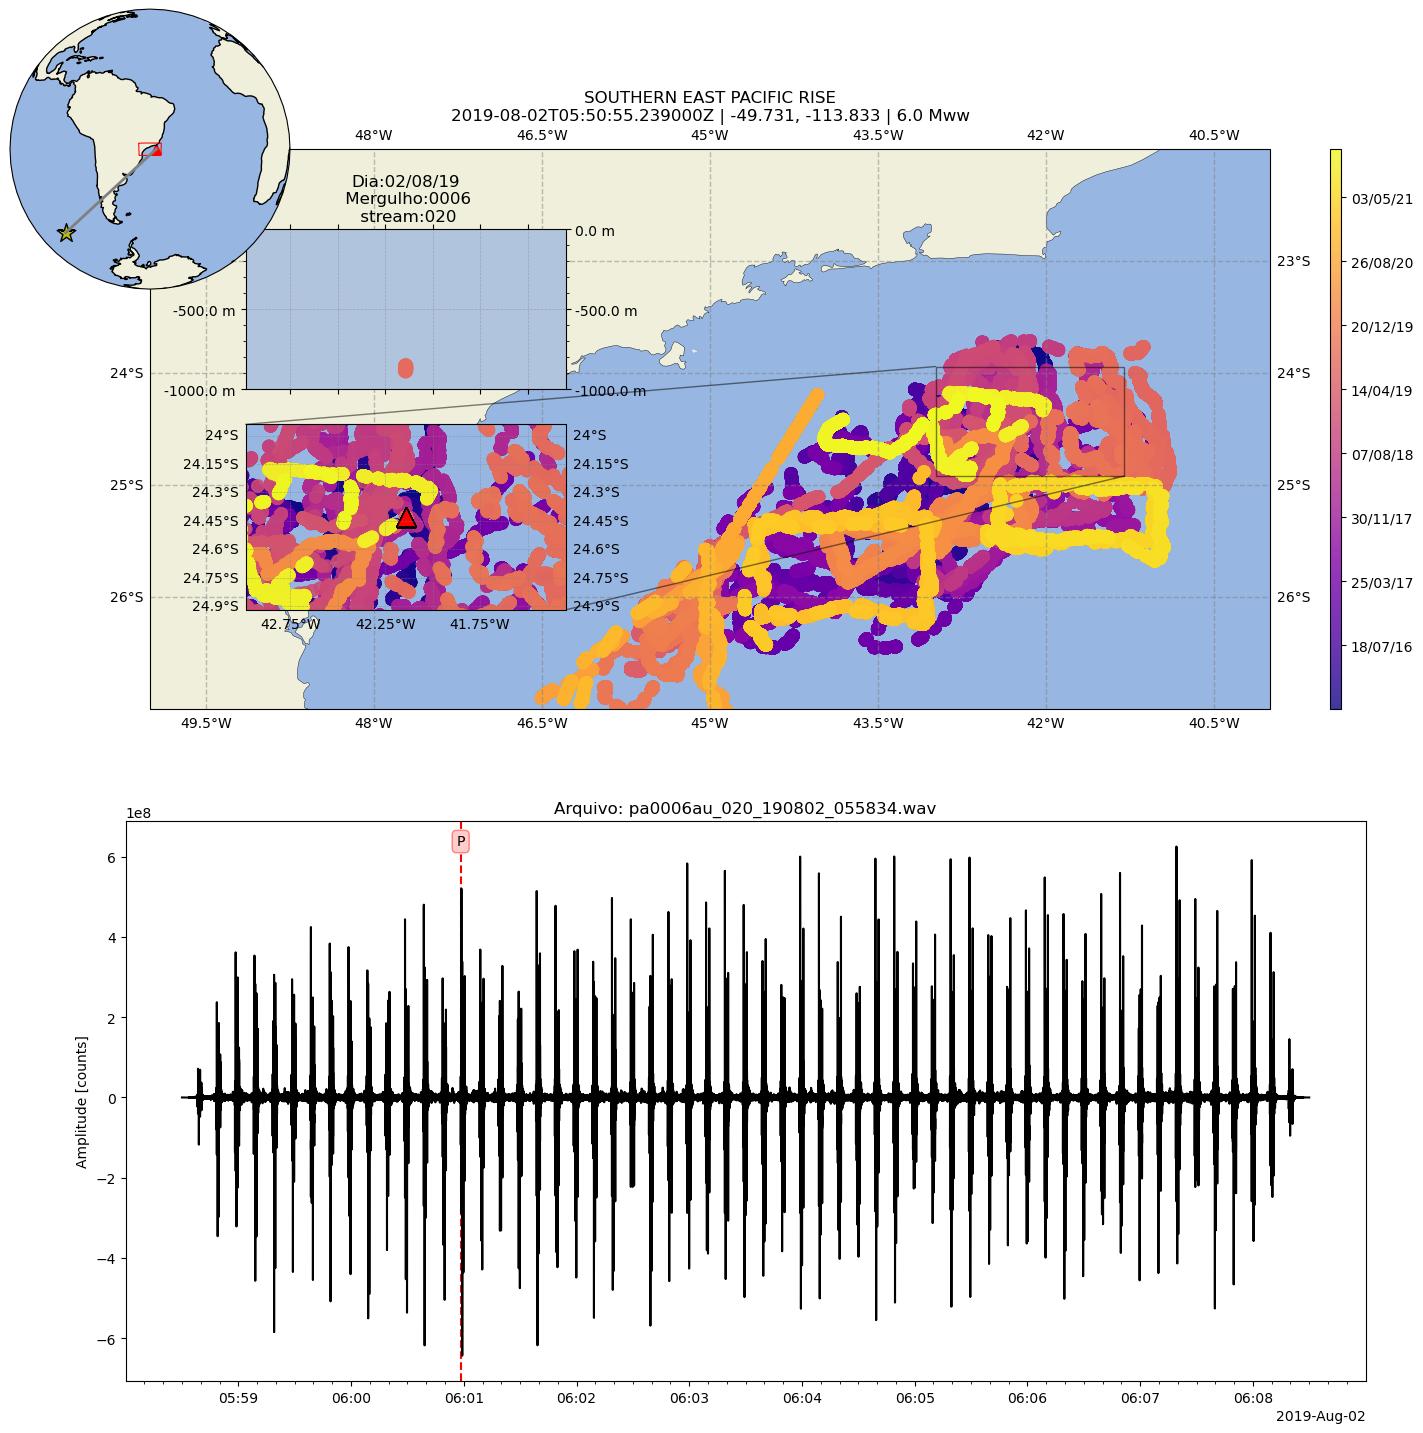

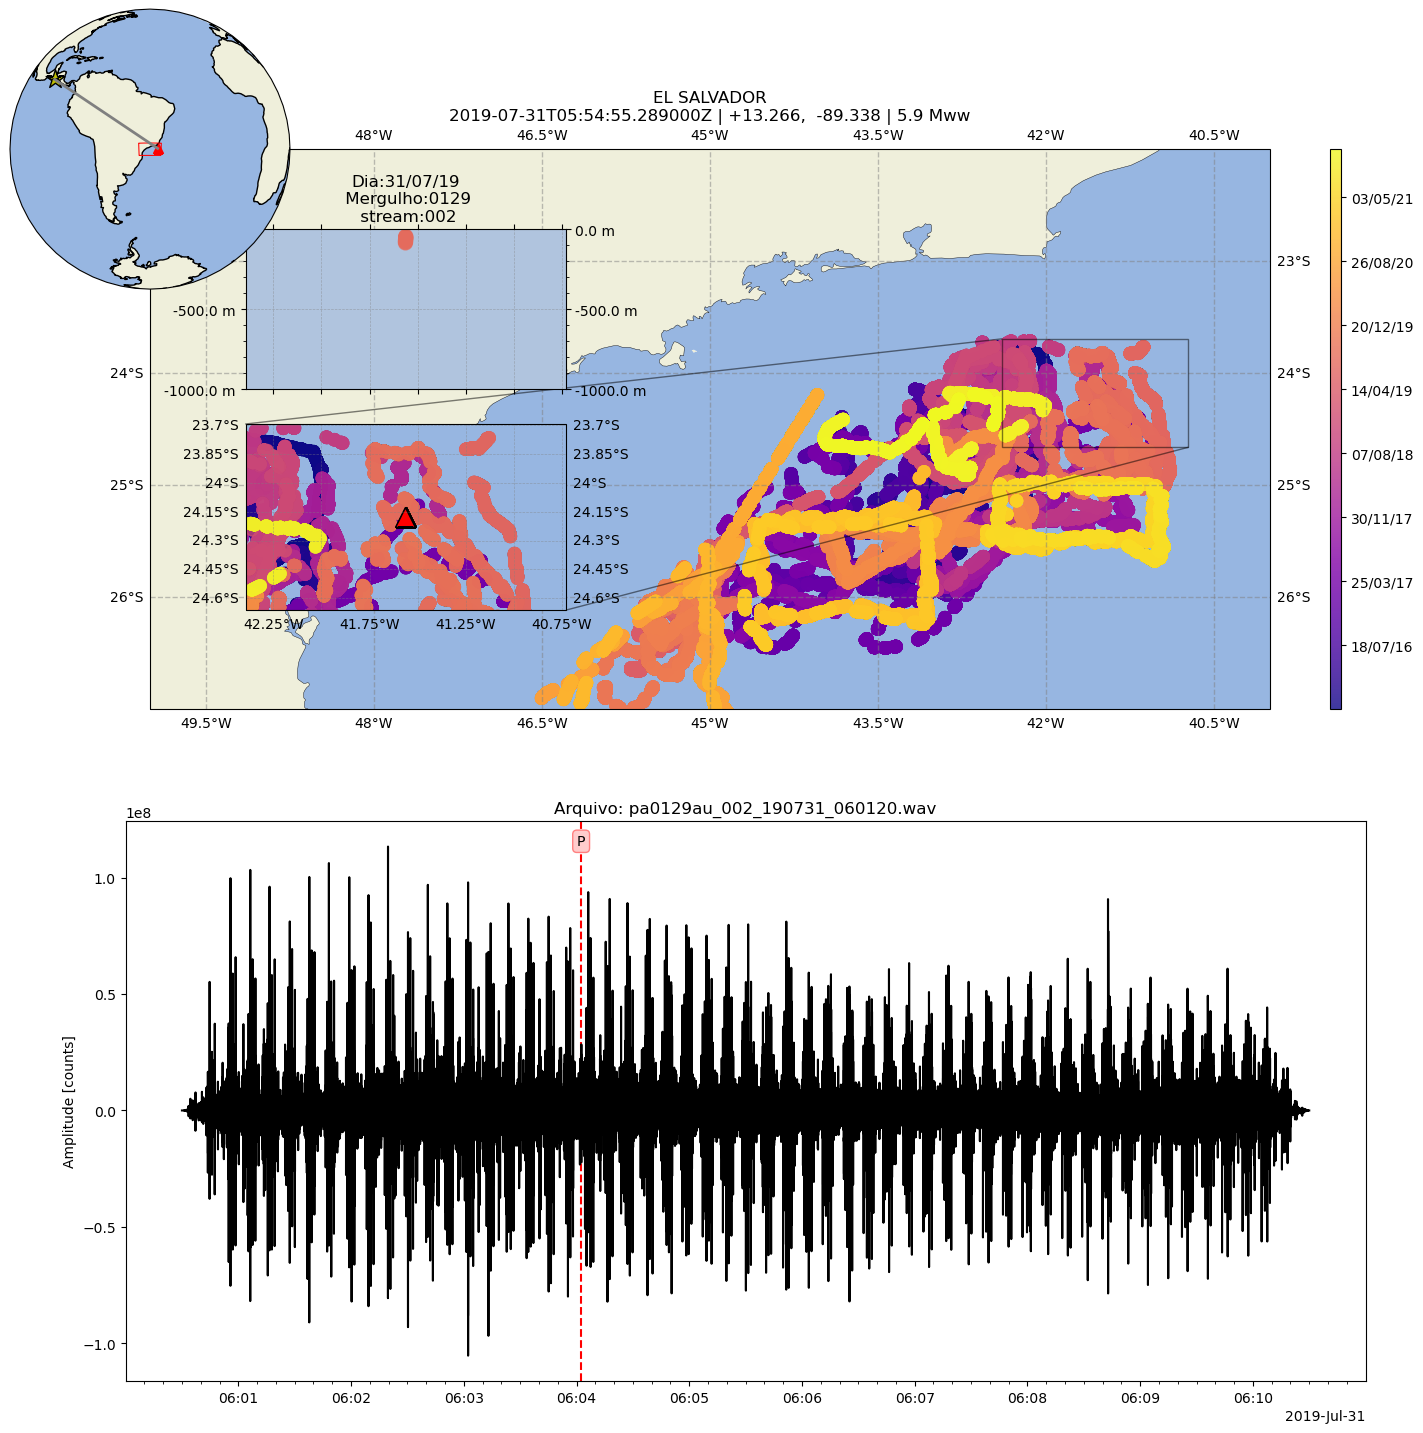

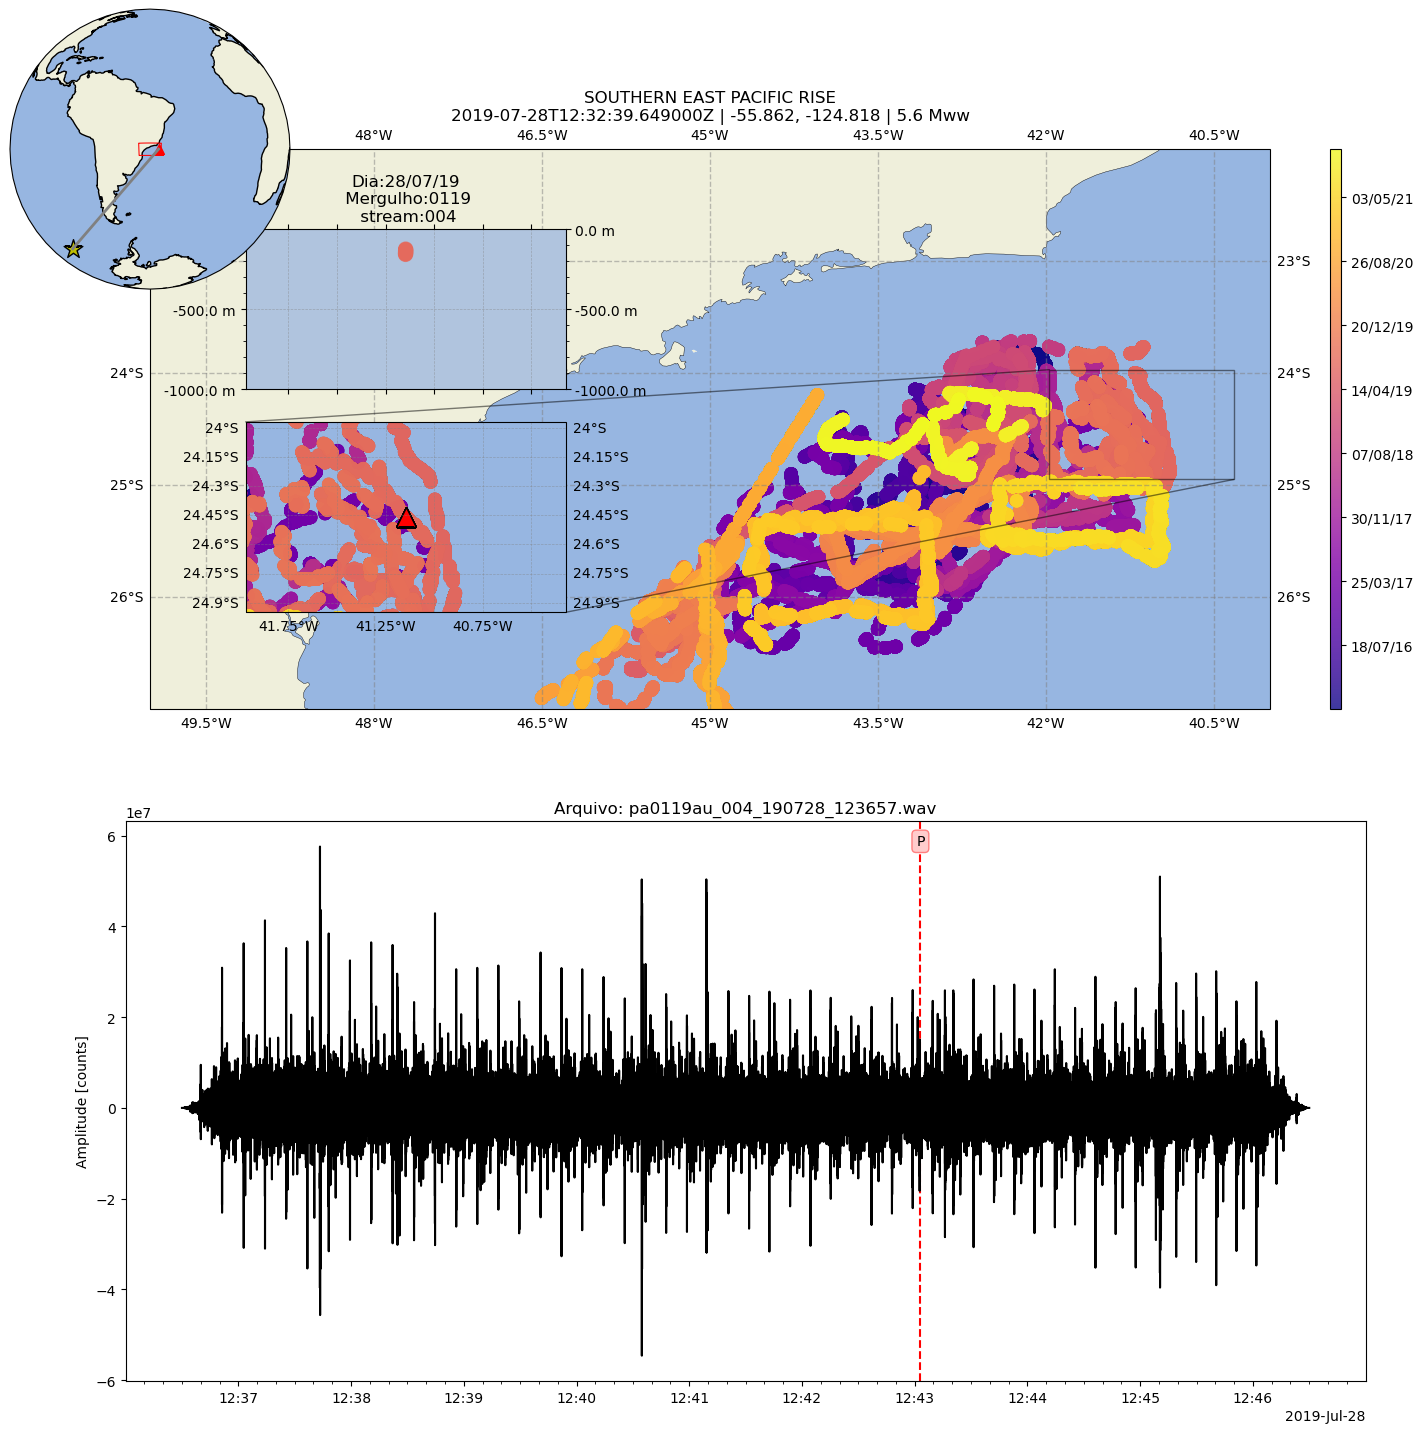

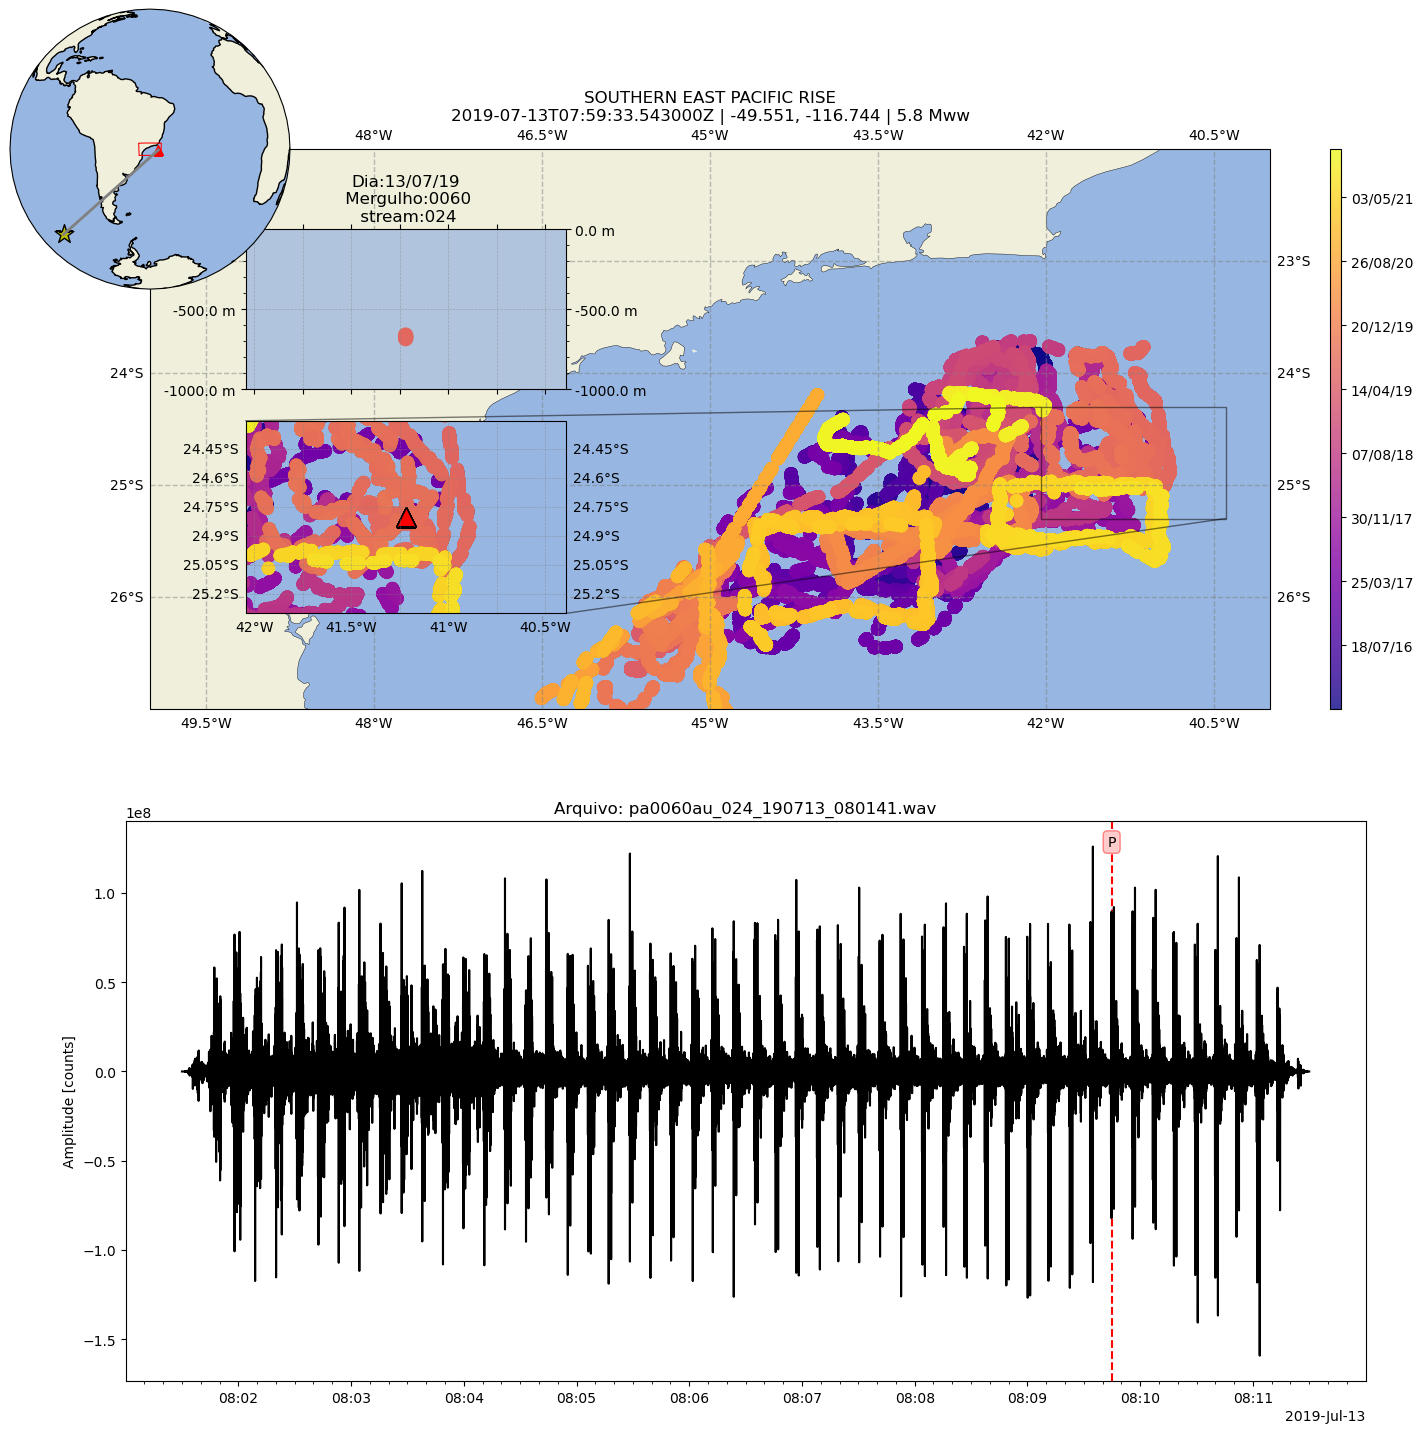

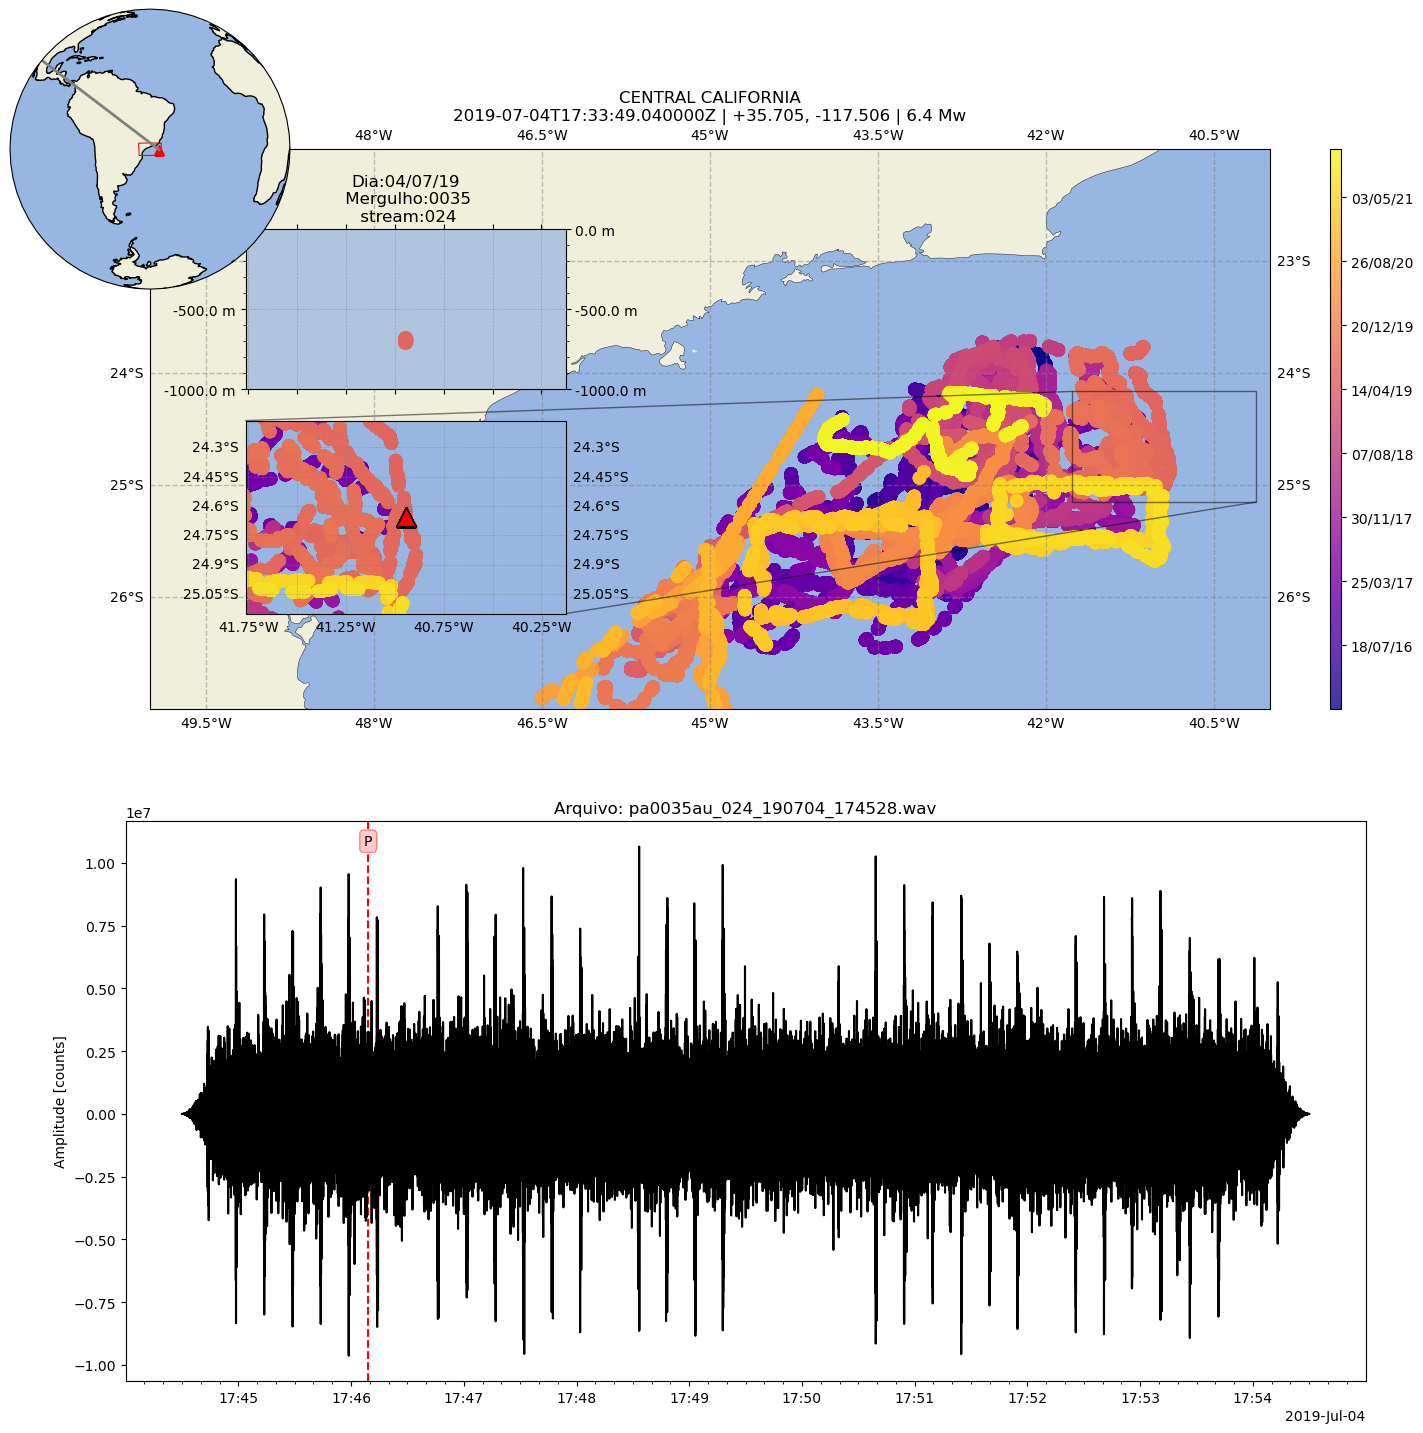

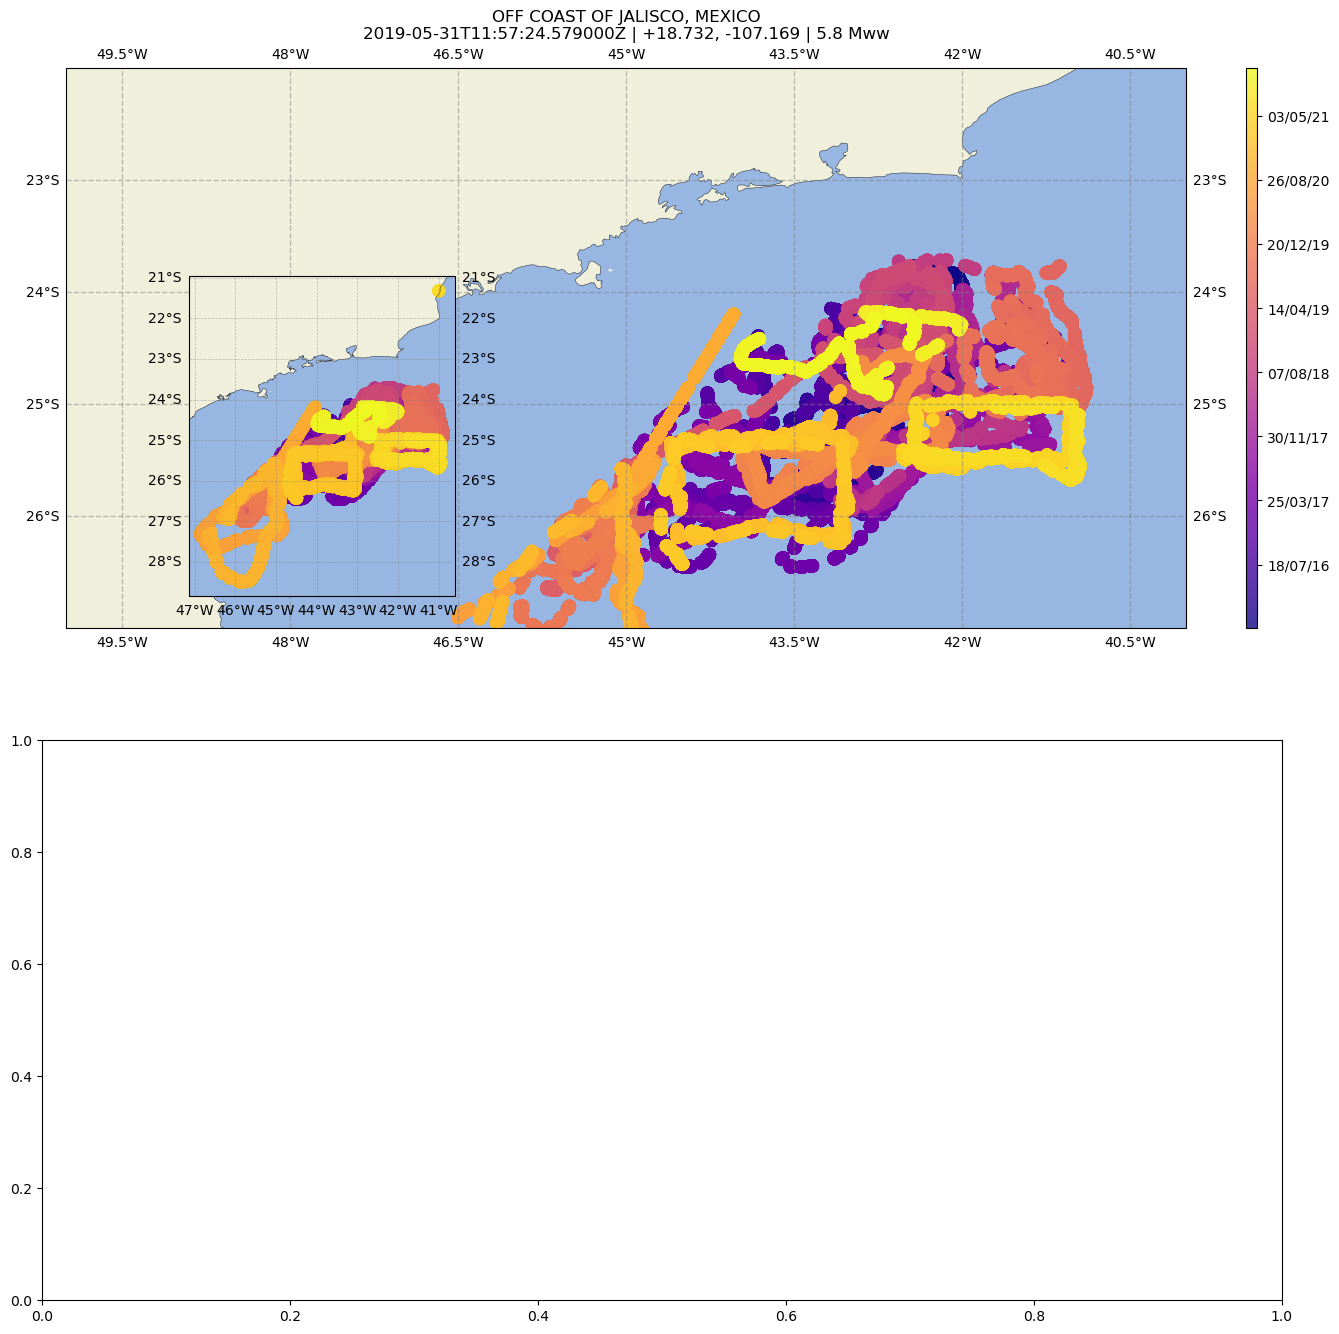

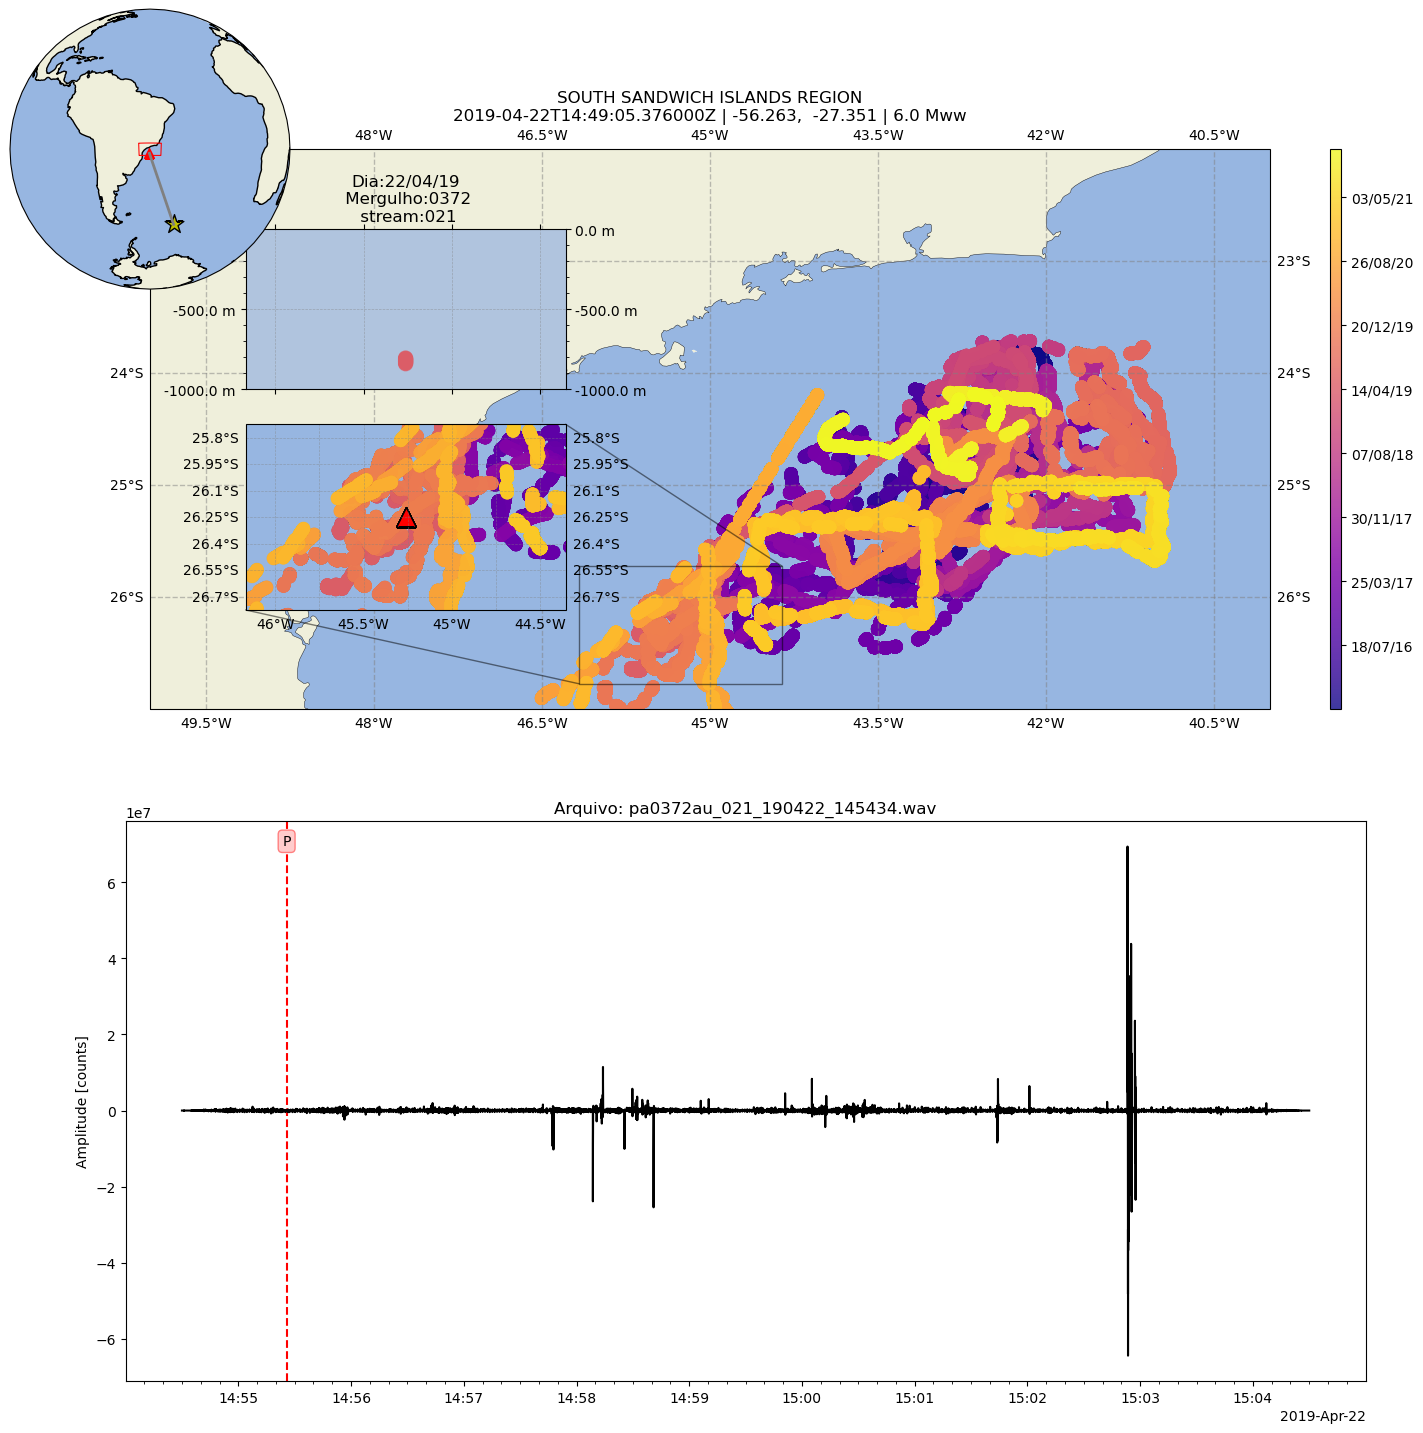

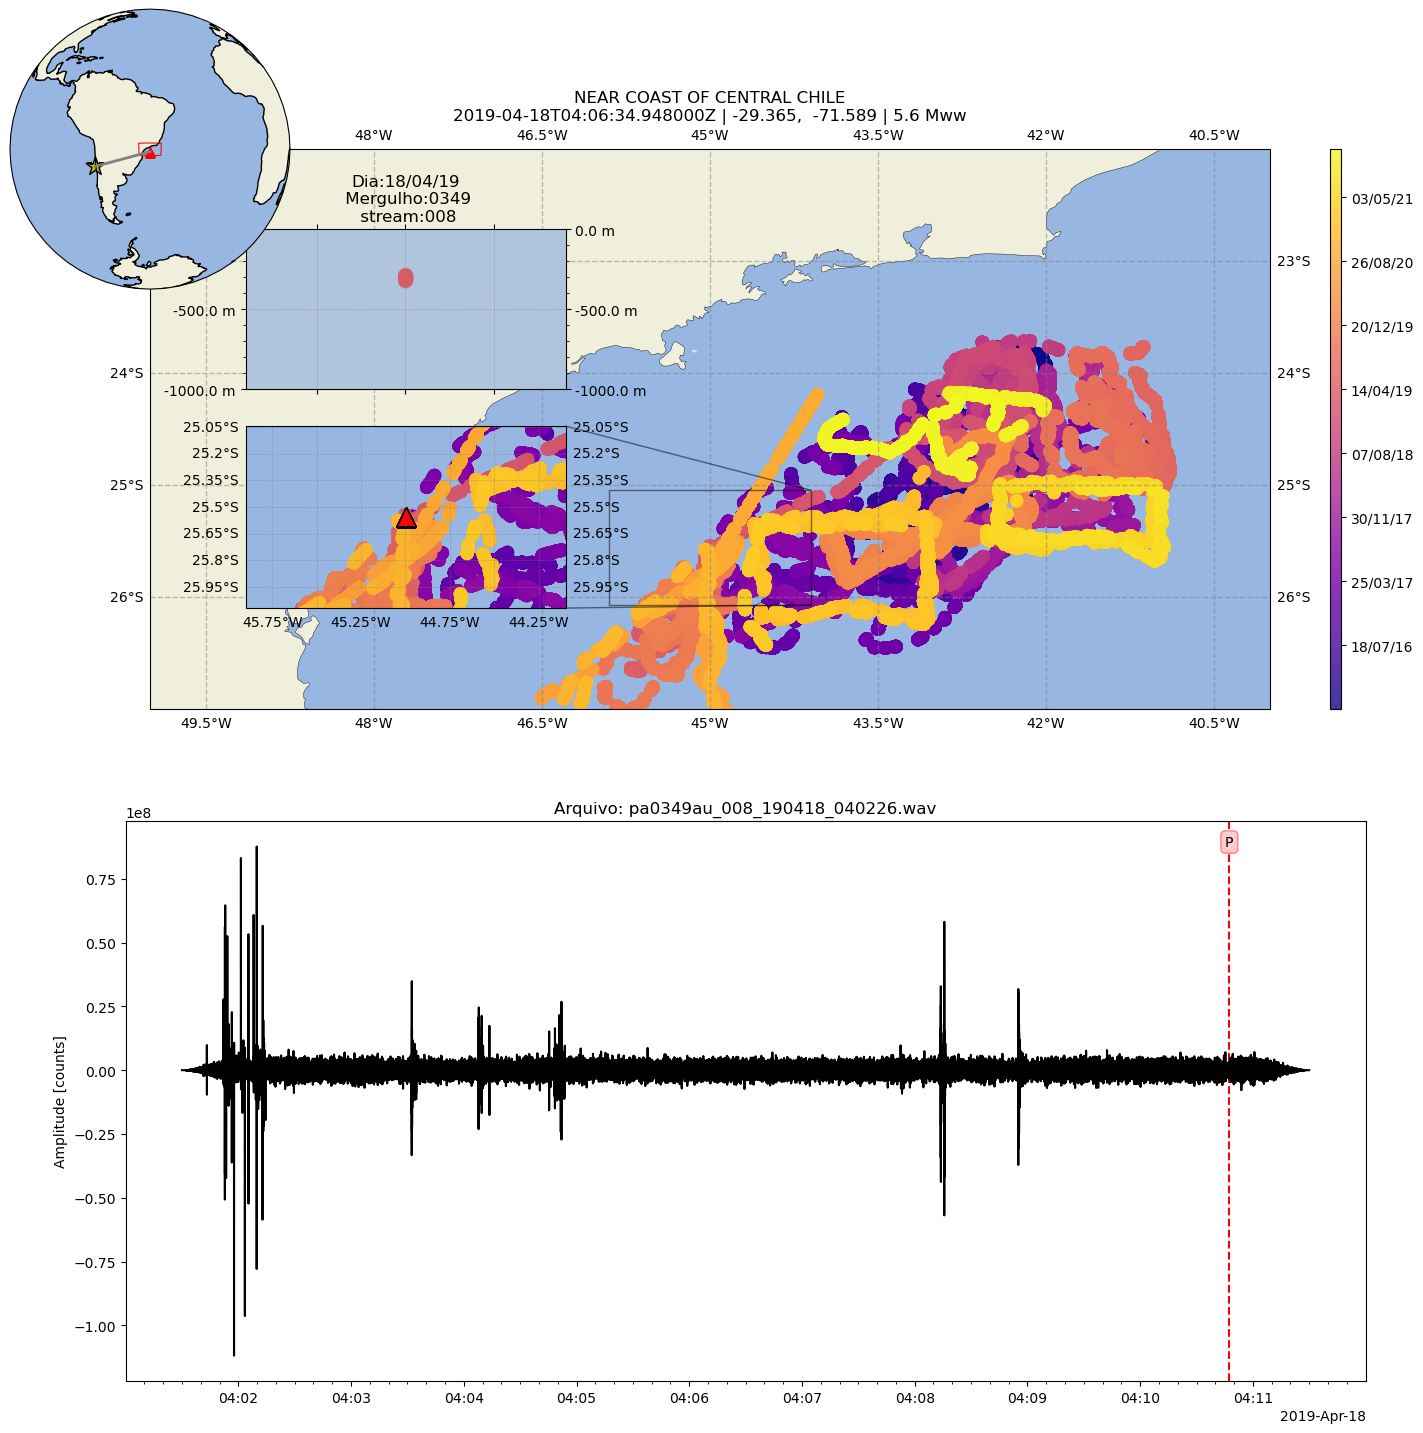

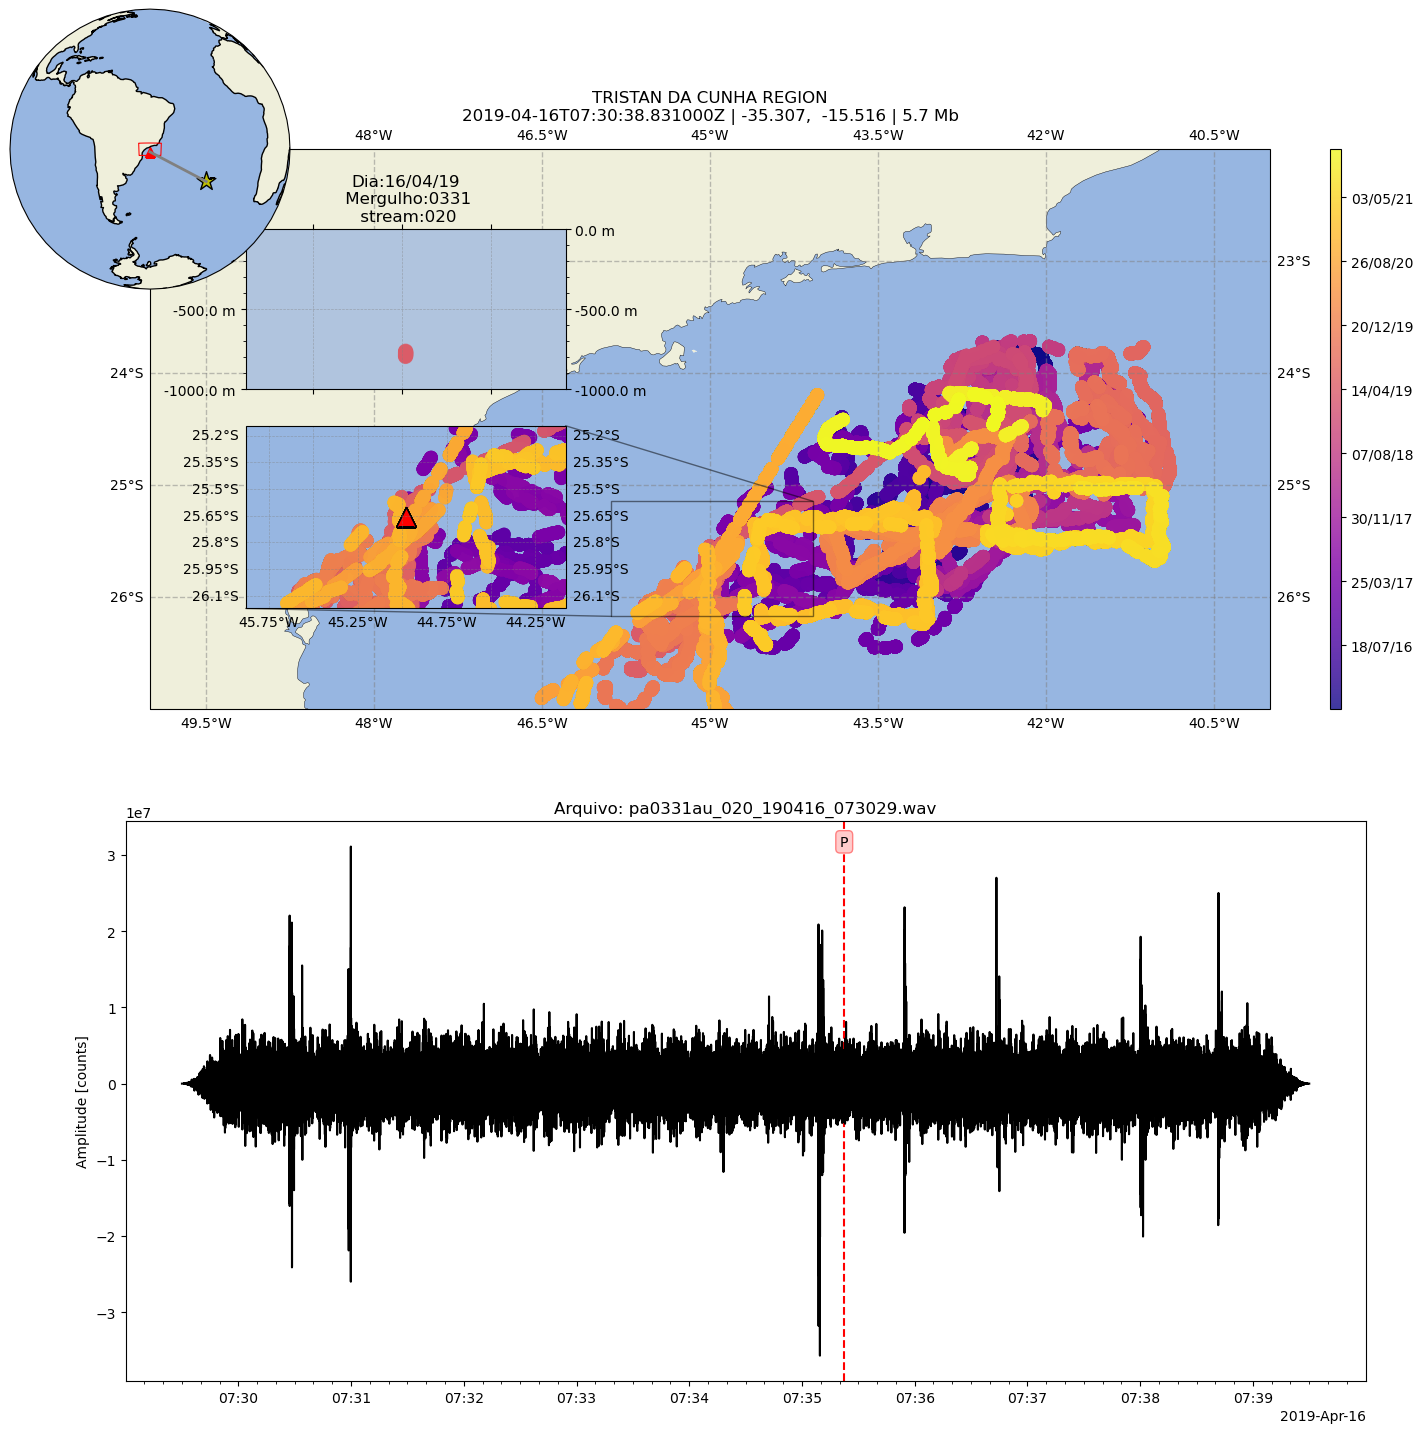

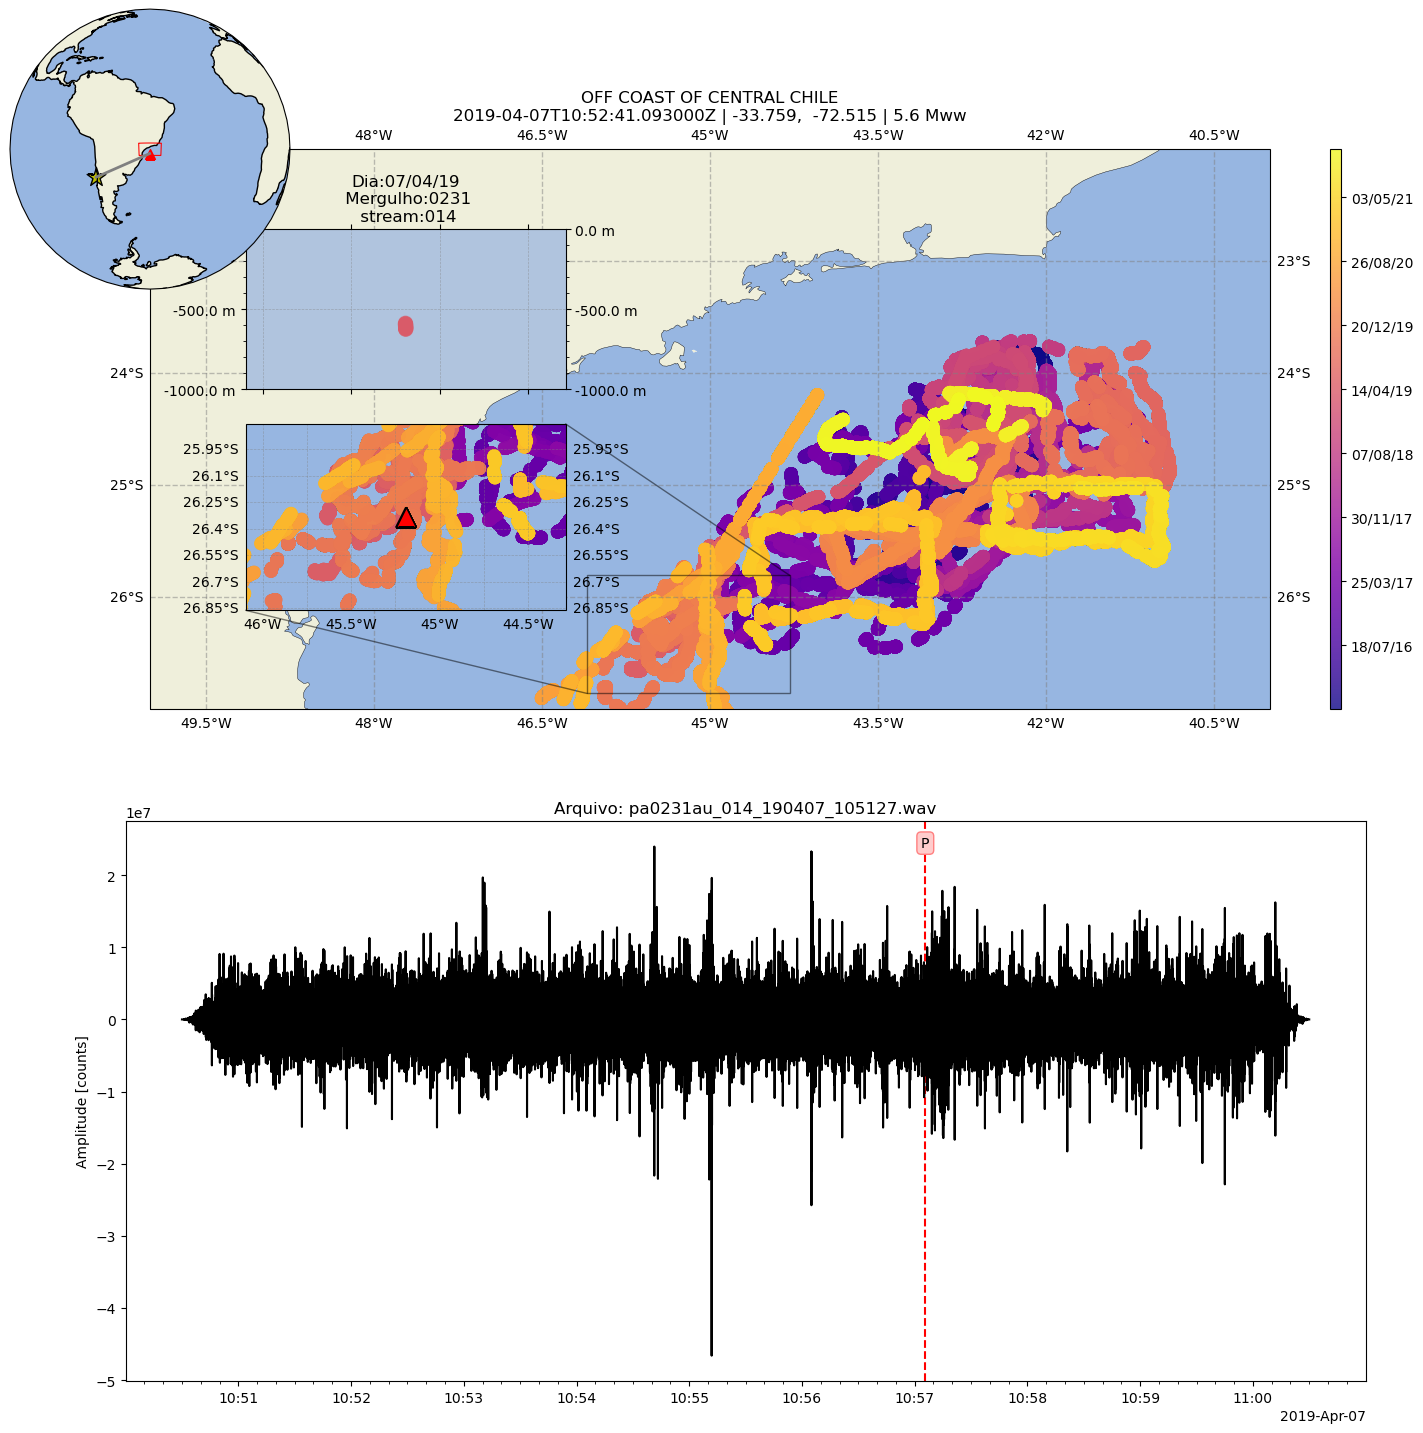

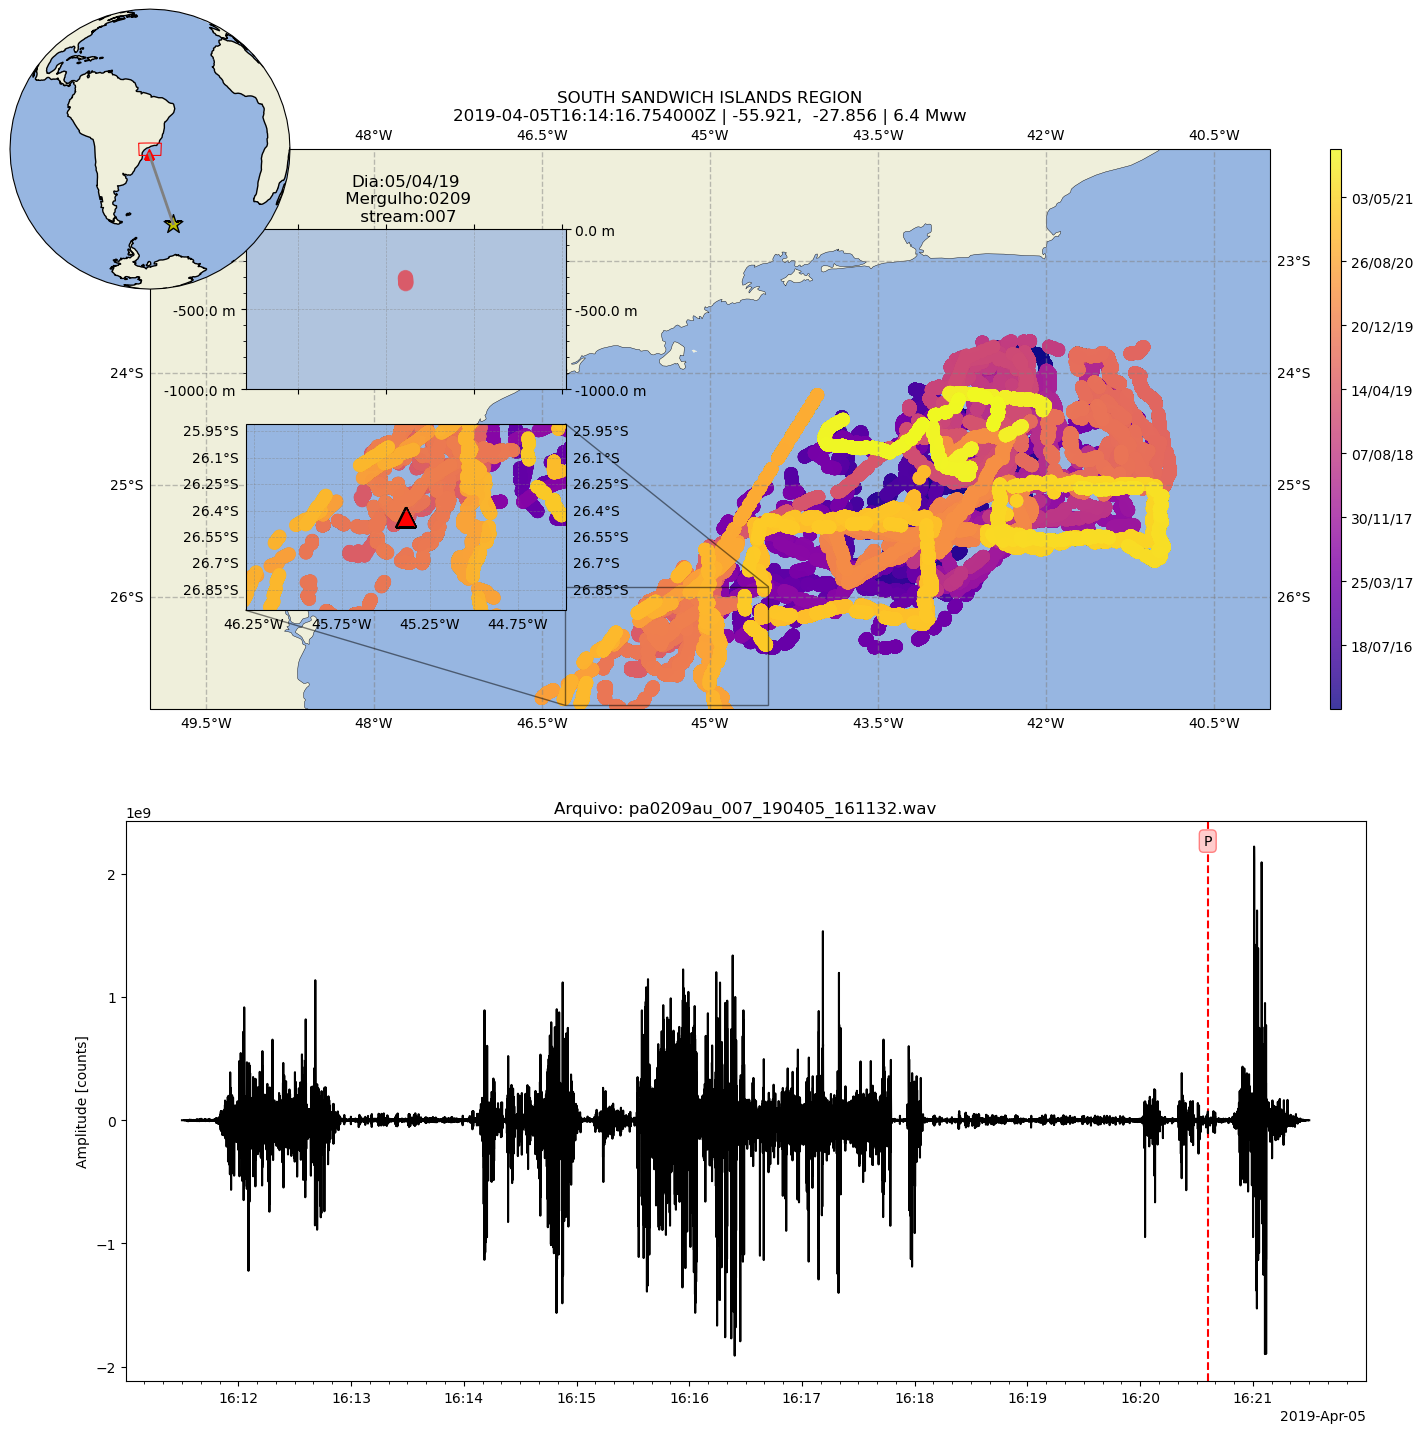

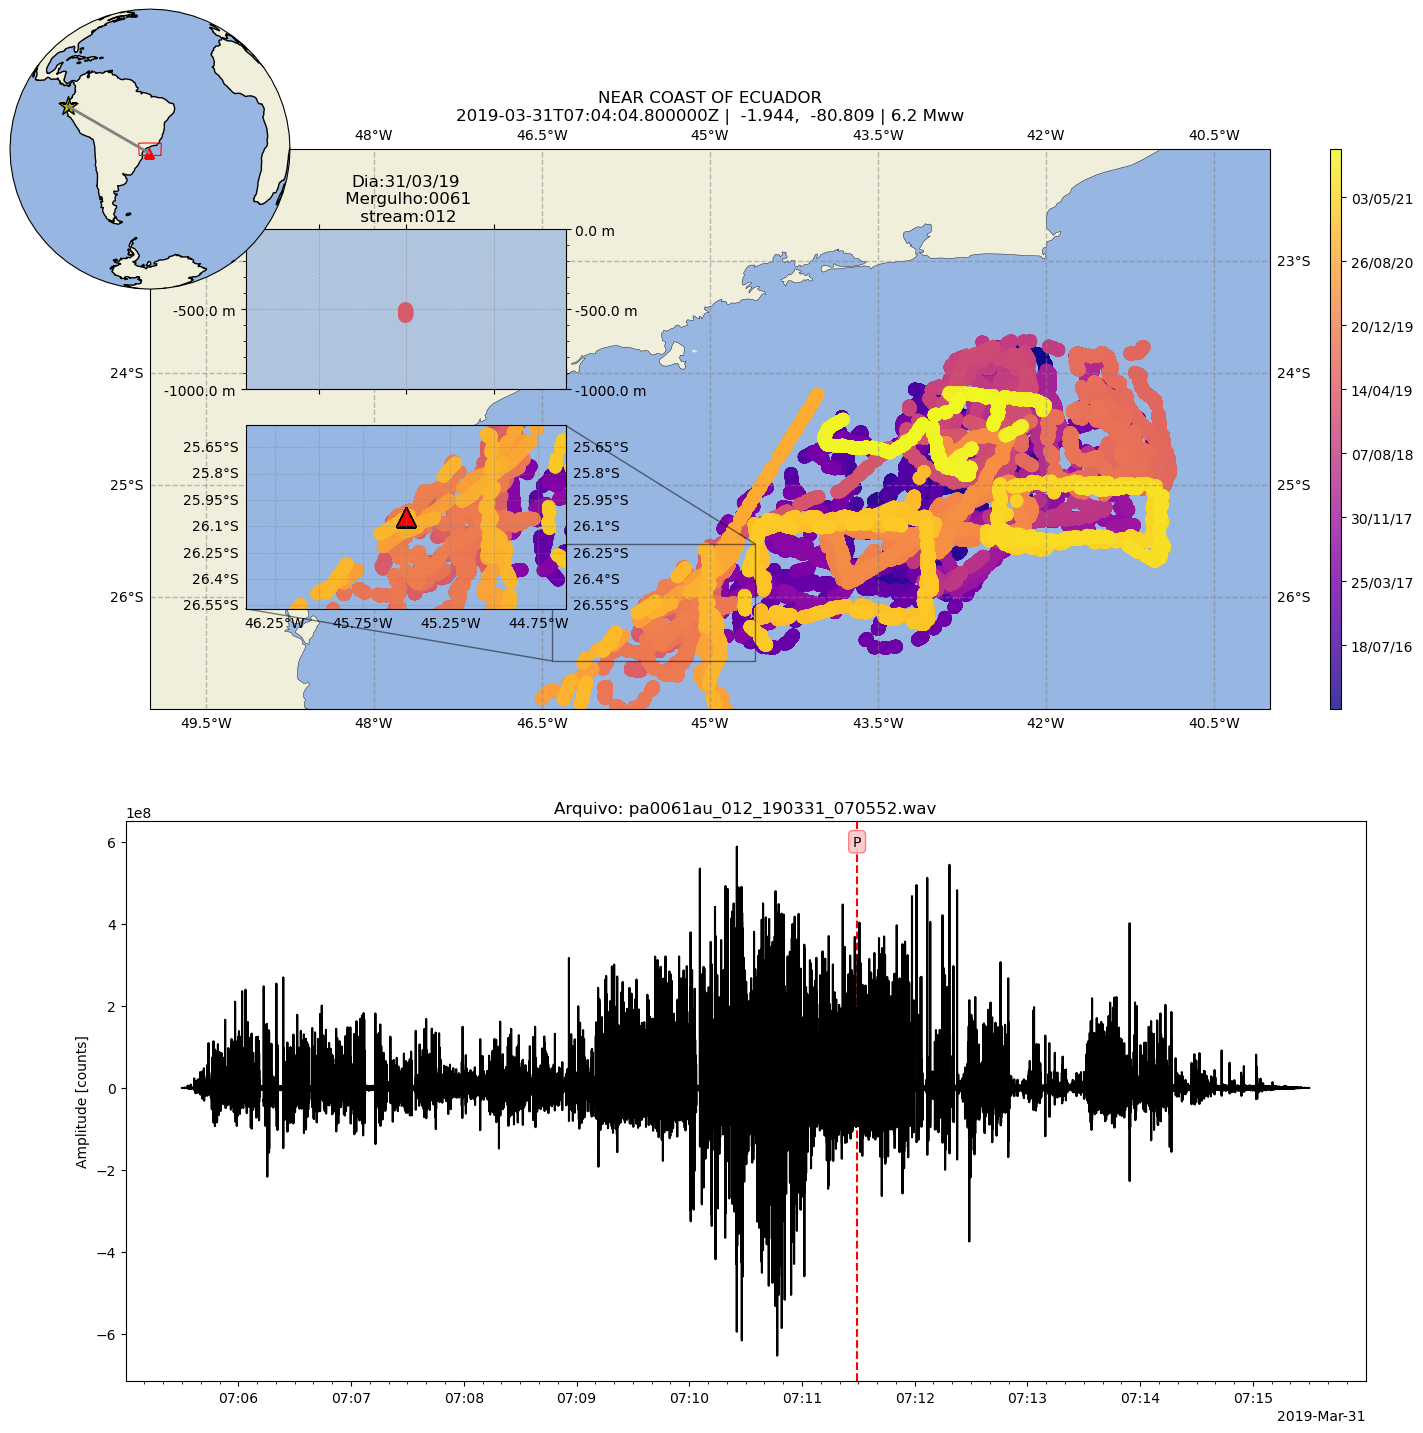

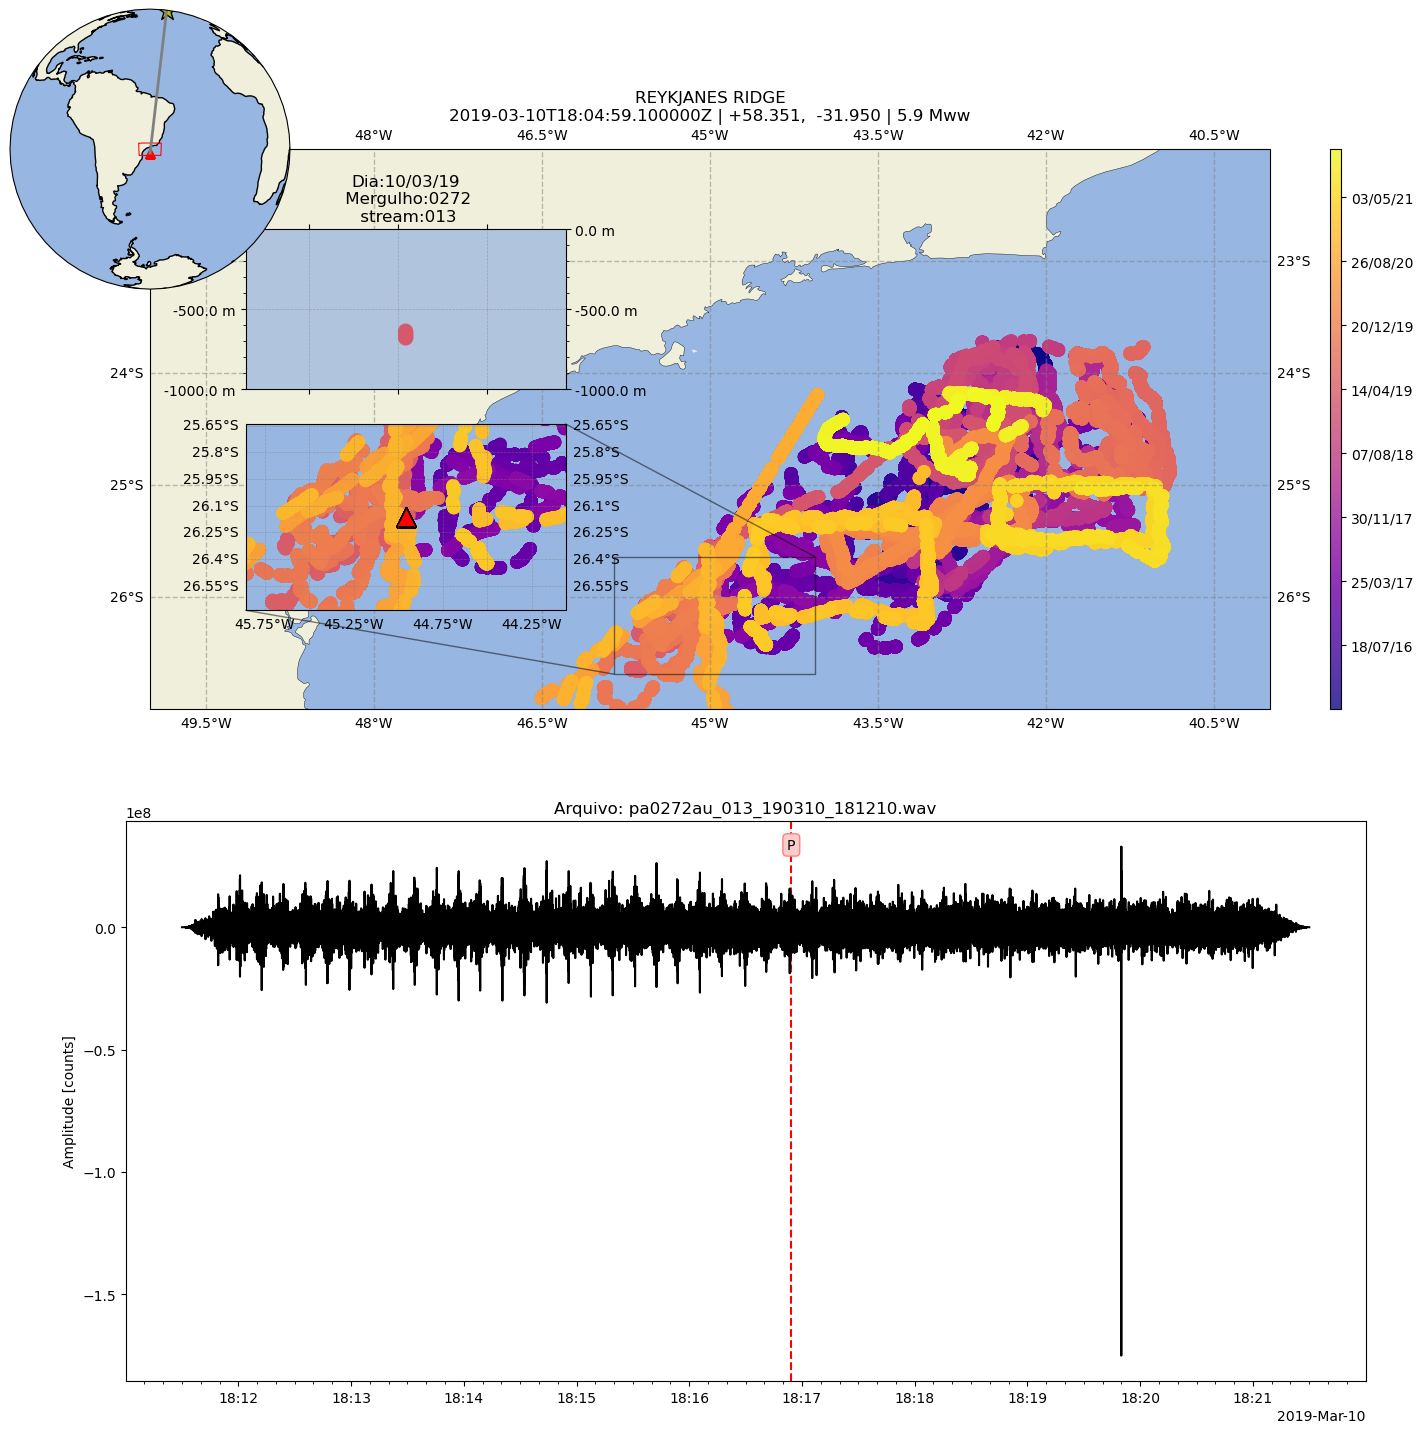

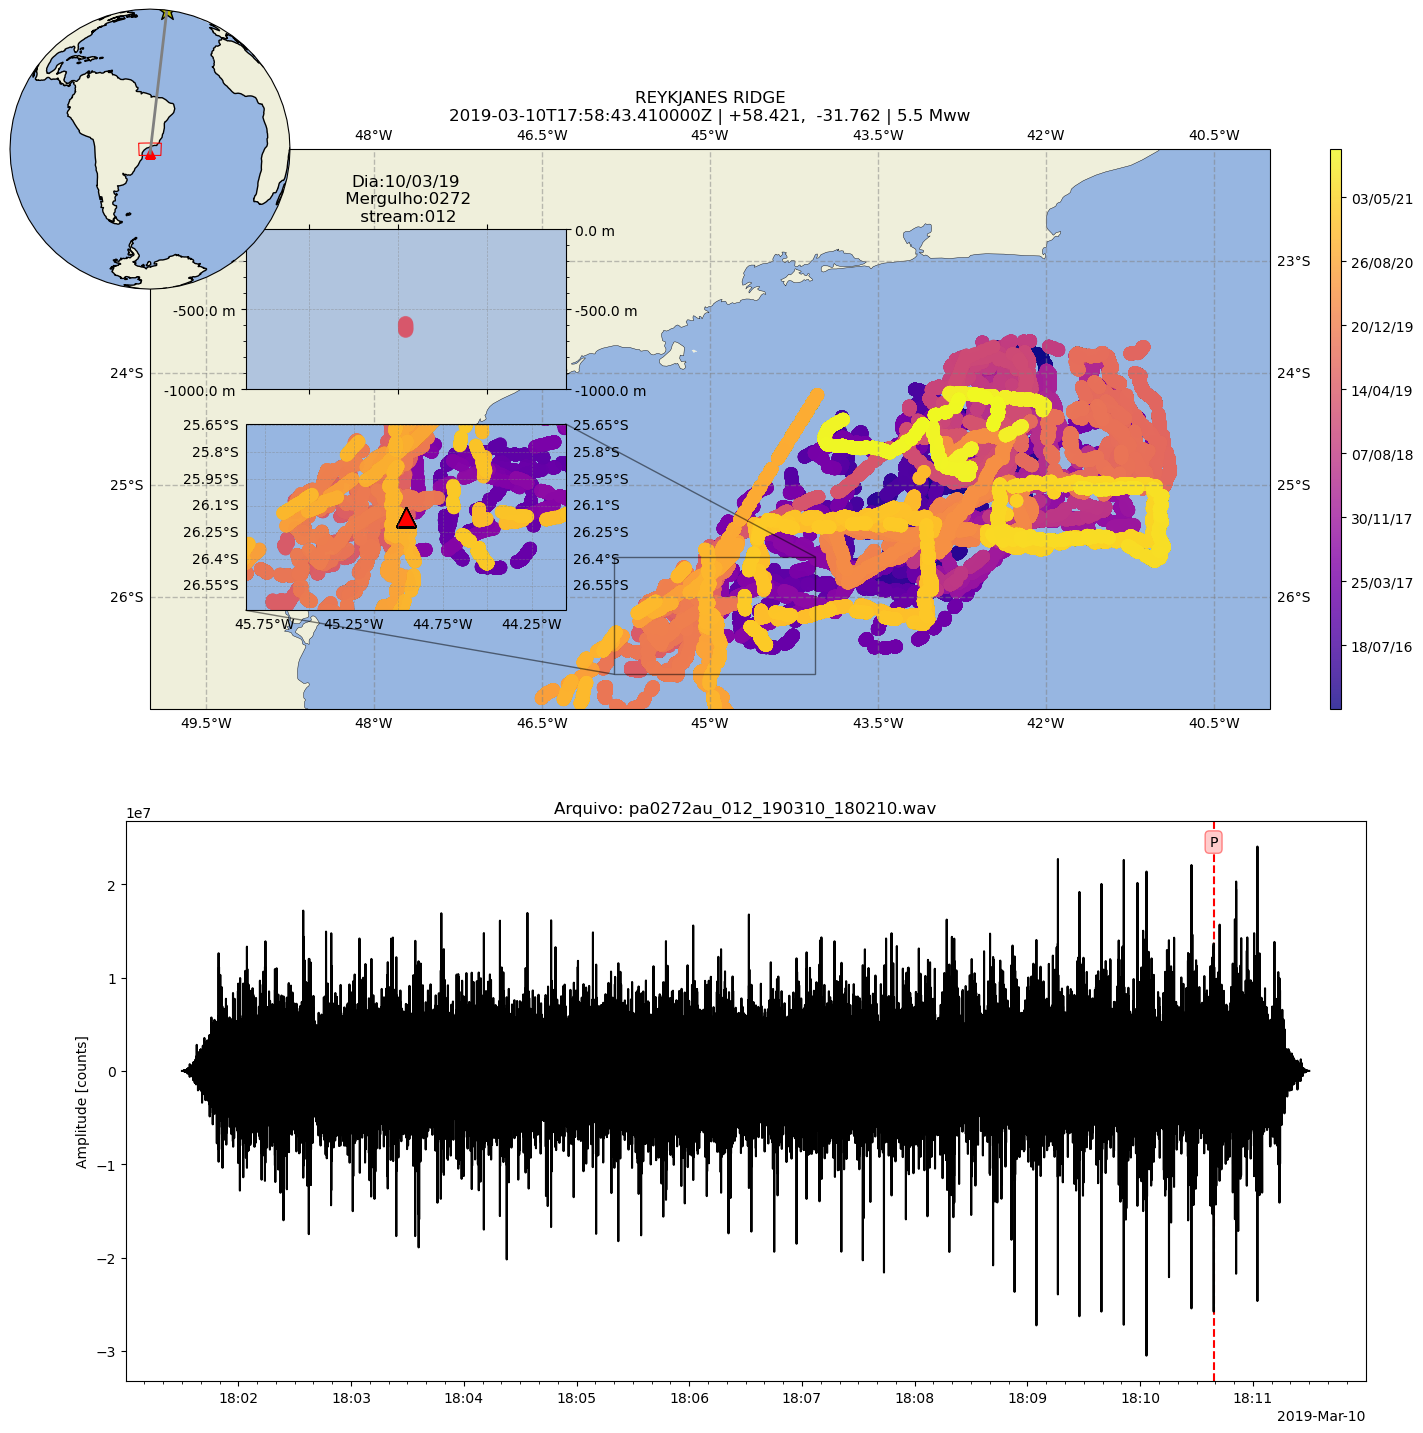

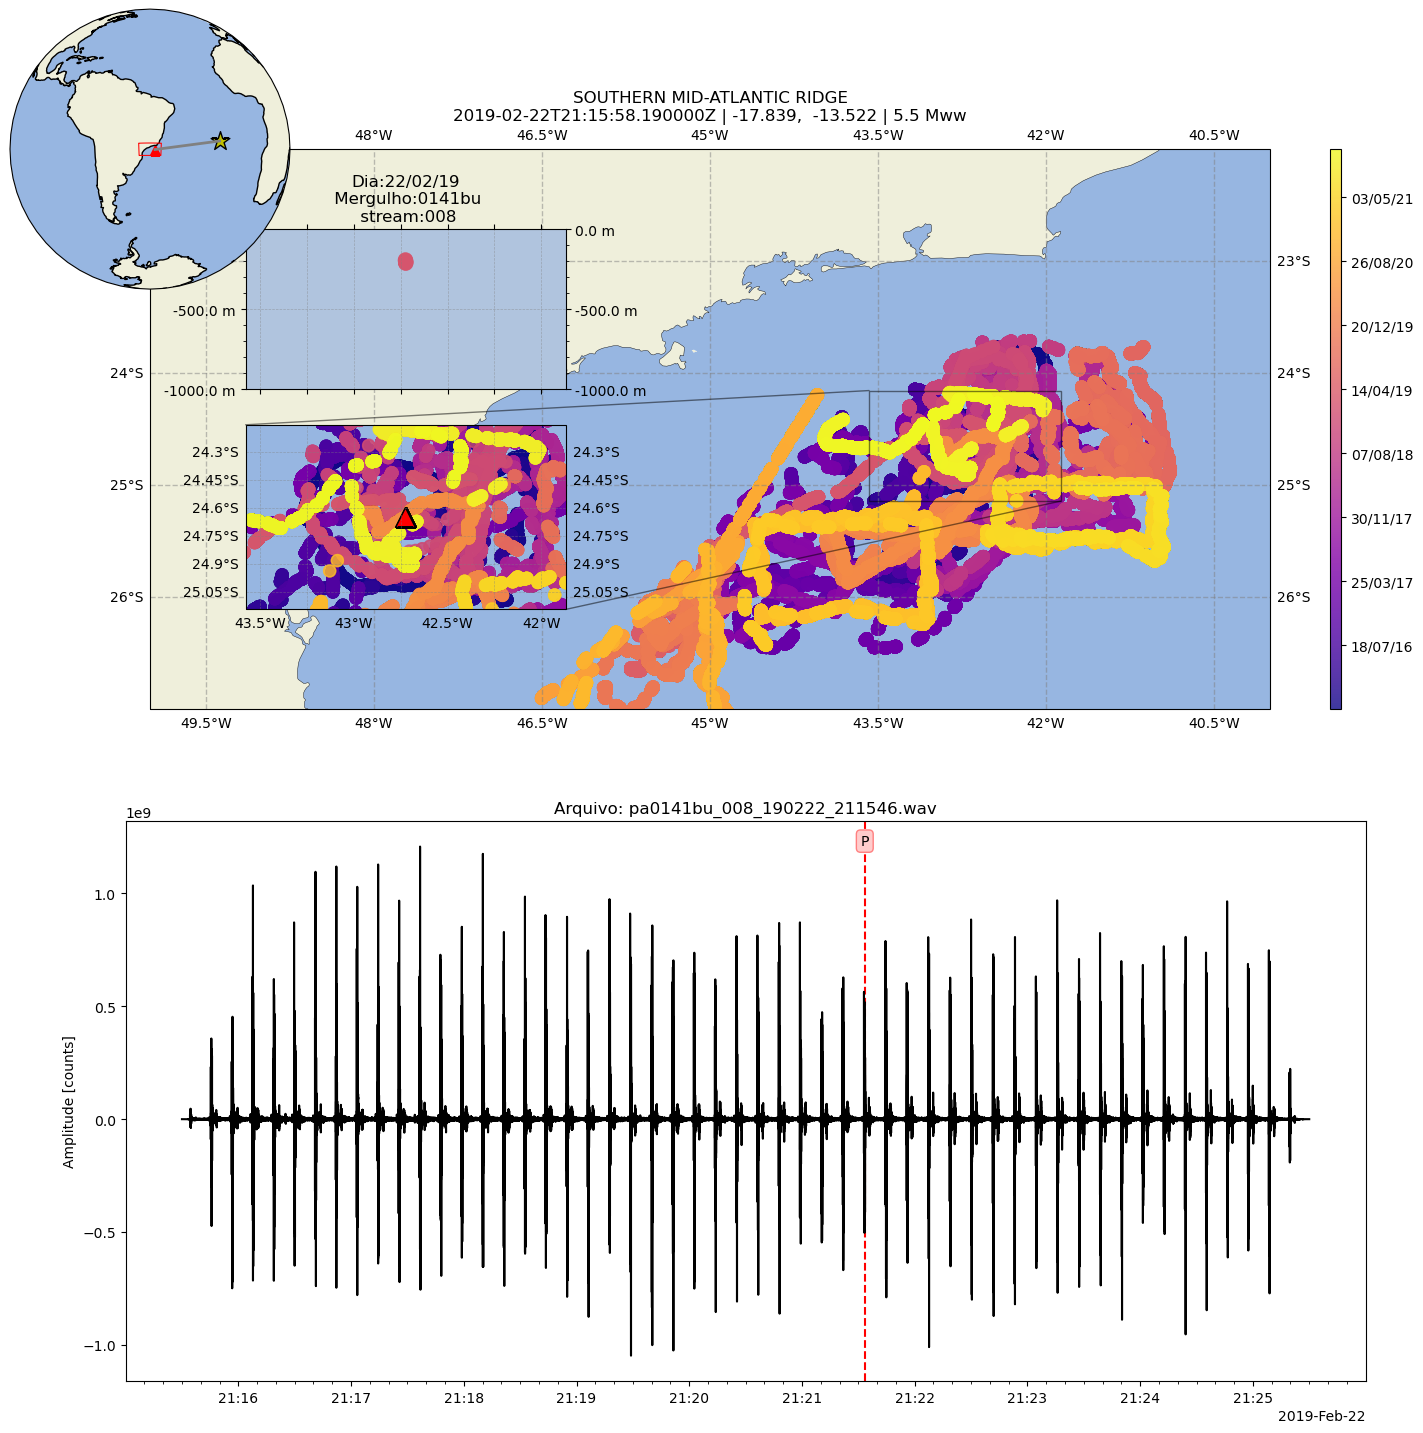

In [ ]:
for ev in tqdm(events,total=len(events)):
    try:
        ev_time = ev.origins[0].time
        ev_lat = ev.origins[0].latitude
        ev_long = ev.origins[0].longitude
        ev_depth =  ev.origins[0].depth/1000
              
        file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
        
        if len(file_mseed_info) != 0 and len(dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_info['filename'].values[0])]) != 0:

            lat_glider_mean = np.mean(dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_info['filename'].values[0])]['latitude'].values)
            lon_glider_mean = np.mean(dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_info['filename'].values[0])]['longitude'].values)  

            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider_mean,lon_glider_mean)
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            
            if gcarc < 100:

                #Calculating ray parameter
                model = TauPyModel(model='iasp91')
                arrivals = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P"])
                arr = arrivals[0]

                #Reference time
                event = ev_time+arr.time

                #########################################################################################################################################################
                #STREAM 
                
                file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event)]

                if len(file_mseed_event) != 0:

                    lat_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['latitude'].values
                    lon_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['longitude'].values        
                    depth_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['depth'].values       
                    time_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['time'].values        

                    mergulho = file_mseed_event['mergulho'].values[0]
                    stream_number = file_mseed_event['stream_number'].values[0]
                    ev_file_mseed = file_mseed_event['filename'].values[0]
                    file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/'+ev_file_mseed+'*'))[0]
                    
                    stream_mseed = read(file_mseed_ev)[0]
                    
                    #########################################################################################################################################################
                    #Figure 

                    # set up the plot and create a GeoAxes:
                    proj = ccrs.PlateCarree()

                    fig, (ax,ax1) = plt.subplots(2,1,figsize=(16,16))
                    ax = plt.subplot(2, 1, 1, projection=proj)

                    # ----------------------------------------------------------------------------------------------------------
                    # Limit the extent of the map to a small longitude/latitude range.
                    latmin=-27
                    latmax=-22
                    lonmin=-50
                    lonmax=-40

                    ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                    # ----------------------------------------------------------------------------------------------------------
                    # Ploting lat/lon values

                    h = ax.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding background map 
                    ax.add_feature(cfeature.LAND)
                    ax.add_feature(cfeature.OCEAN)
                    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                    ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
                    ax.set_title(ev.event_descriptions[0].text+'\n'+ev.short_str().title())
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding colorbar
                    divider = make_axes_locatable(ax)
                    ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                    fig.add_axes(ax_cb)
                    cb = plt.colorbar(h, cax=ax_cb)
                    cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                    #####################################################
                    # Adding inset axes RIGHT
                    #####################################################

                    axins = plt.axes([0.2, 0.55, 0.2, 0.2],projection=proj)

                    axins.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.3,cmap='plasma',s=75,transform=proj)

                    j = axins.scatter(lon_event_info, lat_event_info, color='r',marker='^',s=200,ec='k',transform=proj)

                    axins.add_feature(cfeature.LAND)
                    axins.add_feature(cfeature.OCEAN)
                    axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                    axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding grid 
                    axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                    # subregion of the original image
                    x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                    x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                    y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                    y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                    axins.set_xlim(x1, x2)
                    axins.set_ylim(y1, y2)

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding ZOOM
                    ax.indicate_inset_zoom(axins, edgecolor="black")

                    # ----------------------------------------------------------------------------------------------------------
                    ax_histx = plt.axes([0.2, 0.73, 0.2, 0.1],sharex=axins,facecolor='lightsteelblue')
                    ax_histx.scatter(lon_event_info,depth_event_info, c=np.array([mdates.date2num(i) for i in time_event_info]),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),alpha=0.7,cmap='plasma',s=100)
                    ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    ax_histx.set_title("Dia:"+mdates.num2date(mdates.date2num(time_event_info[0])).strftime('%d/%m/%y')+"\n Mergulho:"+mergulho+"\n stream:"+stream_number)
                    ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                    ax_histx.set_ylim(-1000,0)
                    ax_histx.yaxis.set_major_formatter('{x} m')
                    ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                    ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding global location map
                    # inset location relative to main plot (ax) in normalized units
                    inset_x = 0
                    inset_y = 1
                    inset_size = 0.5

                    # Adding Geoaxes
                    ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                    ax2.set_global()

                    # Adding background map 
                    ax2.add_feature(cfeature.LAND)
                    ax2.add_feature(cfeature.OCEAN)
                    ax2.add_feature(cfeature.COASTLINE)

                    # Adding inset geoaxes position
                    ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                            inset_y - inset_size / 2,
                                            inset_size,
                                            inset_size])
                    ax2.set_axes_locator(ip)


                    # Adding red rectangle position
                    nvert = 100
                    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
                    lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

                    ring = LinearRing(list(zip(lons, lats)))
                    ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                    ax2.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                    ax2.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                    ax2.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding stream plot

                    ax1.text(x=event.matplotlib_date,y=np.max(stream_mseed.data)+abs(np.max(stream_mseed.data)/50),s="P",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                    ax1.plot(stream_mseed.times('matplotlib'),stream_mseed.data,'-k')        
                    ax1.set_ylabel('Amplitude [counts]')
                    locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                    formatter = mdates.ConciseDateFormatter(locator)
                    ax1.xaxis.set_major_locator(locator)
                    ax1.xaxis.set_major_formatter(formatter)
                    mins2 = SecondLocator(interval=60)
                    mins1 = SecondLocator(interval=10)
                    ax1.xaxis.set_major_locator(mins2)
                    ax1.xaxis.set_minor_locator(mins1)
                    ax1.set_title('Arquivo: '+ev_file_mseed+'.wav')
                    # ----------------------------------------------------------------------------------------------------------
                    # Saving figure
                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED/',exist_ok=True)
                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED/event_mseed_'+event.strftime('%Y_%m_%d_%H_%M_%S')+'_'+ev_file_mseed+'.png')
    except:
        pass